In [1]:
from __future__ import absolute_import, division, print_function

import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams["text.usetex"]=False 

In [2]:
%matplotlib inline
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>")

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]) #in MB

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


2023-01-26 10:31:02.339595: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 10:31:02.339846: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 10:31:02.356443: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 10:31:02.356669: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 10:31:02.356842: I tensorflow/compiler/xla/stream_executo

In [4]:
# Define default plot styles  

from matplotlib import rc
import matplotlib.font_manager

rc('font', family='serif')
rc('text', usetex=False)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': False
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': False
}

plot_style_2 = {'alpha': 0.5, 'density': False}

In [5]:
# Check Versions
import tensorflow as tf
print(tf.__version__)

2.11.0


# OmniFold Gaussian Toy Example

## Setup the Datasets

In [6]:
mu0 = 0
sigma0 = 1

eff = 0.1 #fraction of true but not reco
fake = 0.1 #fraction of reco but not true


##-- original value
#back = 0.1 #fraction of a background process that we would like to subtract



## Owen: learning hyperparameters

In [7]:



##-- originals

max_epochs = 200
batch_size_setval = 10000
learning_rate_setval = 1e-3
patience_setval = 10

back = 0.1 #fraction of a background process that we would like to subtract
background_param = (0, 1.2)  # background
N = 10**5






##-- alt1
##-- more thorough set with more events, higher background, wider background width 
##  3 min + 50 min

#max_epochs = 200
#batch_size_setval = 1000
#learning_rate_setval = 1e-4
#patience_setval = 40

#back = 0.2 #fraction of a background process that we would like to subtract
#background_param = (0, 3)  # background
#N = 3*10**5






##-- alt2
##-- more thorough set with a lot more events, higher background, wider background width 
##   About 3 hours.

#max_epochs = 200
#batch_size_setval = 1000
#learning_rate_setval = 1e-4
#patience_setval = 40

#back = 0.2 #fraction of a background process that we would like to subtract
#background_param = (0, 3)  # background
#N = 10**6





In [8]:
%%time

#N = 10**5


# param = (mu, sigma)
theta0_param = (mu0, sigma0)  # synthetic sample
theta_unknown_param = (0.2, 0.8)  # this is the data (the target)
#background_param = (0, 1.2)  # background
#background_param = (0, 3)  # background
epsilon = sigma0 / 2.  # Smearing width

dummyval = -10 #a value for examples that don't pass one of the measured/ideal selections

#Synthetic
theta0_G = np.random.normal(theta0_param[0], theta0_param[1],N)  # Generator-level synthetic sample
theta0_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta0_G])  # Detector smearing for synthetic sample
pass_reco = np.random.binomial(1,1.-eff,len(theta0_G))
pass_truth = np.random.binomial(1,1.-fake,len(theta0_G)) # what a concise Toy MC with cuts!
theta0_S[pass_reco==0] = dummyval
theta0_G[pass_truth==0] = dummyval

theta0_background = np.random.normal(background_param[0],background_param[1], int(N*back))
theta0_S_withback = np.concatenate([theta0_S,theta0_background]) #smeared synthetic (mc_reco)+background
theta0_G_withback = np.concatenate([theta0_G,-np.ones(int(N*back))*dummyval]) #gen synthetic (mc_truth)+background

theta0 = np.stack([theta0_G, theta0_S], axis=1)
labels0 = np.zeros(len(theta0))

#Natural
theta_unknown_G = np.random.normal(theta_unknown_param[0],theta_unknown_param[1], N) # Nature, particle-level analog
theta_unknown_S = np.array([(x + np.random.normal(0, epsilon)) for x in theta_unknown_G]) # Measured Data analog
pass_reco = np.random.binomial(1,1.-eff,len(theta_unknown_G))
pass_truth = np.random.binomial(1,1.-fake,len(theta_unknown_G))
theta_unknown_S[pass_reco==0] = dummyval
theta_unknown_G[pass_truth==0] = dummyval #emulates cuts done in an analysis

theta_background = np.random.normal(background_param[0],background_param[1], int(N*back))
theta_unknown_S_withback = np.concatenate([theta_unknown_S,theta_background]) #Nature+background
theta_unknown_G_withback = np.concatenate([theta_unknown_G,-np.ones(int(N*back))*dummyval]) #Data+Background

theta_unknown = np.stack([theta_unknown_G, theta_unknown_S], axis=1)
labels_unknown = np.ones(len(theta_unknown))

CPU times: user 510 ms, sys: 0 ns, total: 510 ms
Wall time: 510 ms


In [9]:
theta0_G

array([  0.87648959, -10.        ,   0.07778575, ...,   0.46706359,
        -0.26411385,  -0.8061319 ])

In [10]:
theta0_S

array([-10.        ,  -1.30457596,   0.01453938, ...,  -0.1475477 ,
        -0.06189168,   0.31466274])

In [11]:
theta0

array([[  0.87648959, -10.        ],
       [-10.        ,  -1.30457596],
       [  0.07778575,   0.01453938],
       ...,
       [  0.46706359,  -0.1475477 ],
       [ -0.26411385,  -0.06189168],
       [ -0.8061319 ,   0.31466274]])

In [12]:
labels0

array([0., 0., 0., ..., 0., 0., 0.])

In [13]:
labels0.shape

(100000,)

In [14]:
theta0.shape

(100000, 2)

In [15]:
labels_unknown

array([1., 1., 1., ..., 1., 1., 1.])

In [16]:
labels_unknown.shape

(100000,)

/tmp/ipykernel_2727368/177983796.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


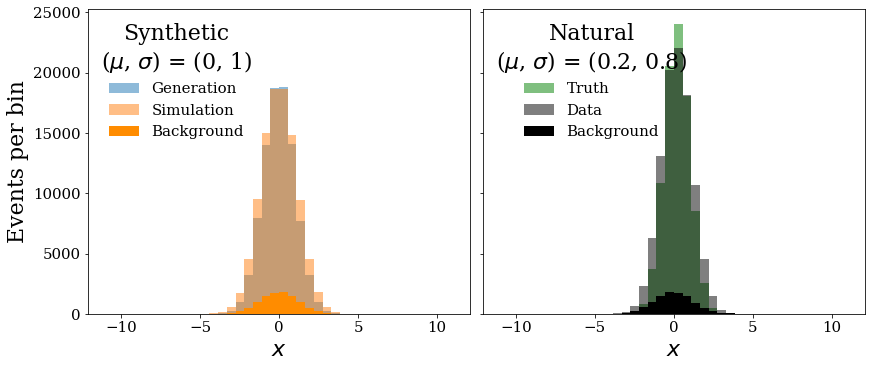

In [17]:
bins = np.linspace(-11, 11, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'Events per bin')
ax[0].hist(theta0_G[theta0_G!=dummyval], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S_withback[theta0_S_withback!=dummyval], bins=bins, **plot_style_2, label='Simulation')
ax[0].hist(theta0_S_withback[theta0_G_withback==-dummyval], bins=bins, color="darkorange", label='Background')
legend = ax[0].legend(
    title=r'Synthetic''\n''($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel(r'$x$')
ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval], bins=bins, **plot_style_2, label='Truth',color="green")
ax[1].hist(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], bins=bins, **plot_style_2, label='Data',color="black")
ax[1].hist(theta_unknown_S_withback[theta_unknown_G_withback==-dummyval], bins=bins, label='Background',color="black")
legend = ax[1].legend(
    title=r'Natural''\n''($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.show()

## Unfold Data

In [18]:
iterations = 4

In [19]:
xvals_1 = np.concatenate((theta0_S, theta_unknown_S)) #synthetic, measured.
yvals_1 = np.concatenate((labels0, labels_unknown)) 
#QUESTION: At what point are theses mixed? Avoid [0,0,0...0,1,1...1,1,1]
#I think at test_train_split function

xvals_2 = np.concatenate((theta0_G, theta0_G)) 
#QUESTION whay 0_G twice? Because theta_unknown_G is ultimate target (particle level – nature), 
#and can't be used as an input to the training.
yvals_2 = np.concatenate((labels0, labels_unknown))

weights = np.empty(shape=(iterations, 2, len(theta0)))
# shape = (iteration, step, event)


nn_output = np.zeros( shape=(iterations, 2, len(theta0)))

inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

model = Model(inputs=inputs, outputs=outputs)

#earlystopping = EarlyStopping(patience=10,
#                              verbose=1,
#                              restore_best_weights=True)

earlystopping = EarlyStopping(patience=patience_setval,
                              verbose=1,
                              restore_best_weights=True)

2023-01-26 10:31:03.616073: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 10:31:03.616282: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 10:31:03.616457: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 10:31:03.616619: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-26 10:31:03.616779: I tensorflow/compiler/xla/stream_executo

In [20]:
xvals_1

array([-10.        ,  -1.30457596,   0.01453938, ...,   1.44747942,
         1.11526072, -10.        ])

In [21]:
xvals_1.shape

(200000,)

In [22]:
yvals_1

array([0., 0., 0., ..., 1., 1., 1.])

In [23]:
yvals_1.shape

(200000,)

In [24]:
# from NN (DCTR)
def reweight(events):
    f = model.predict(events, batch_size=10000)
    weights = f / (1. - f)
    return np.squeeze(np.nan_to_num(weights)) 
#Question: how is the model passed? Stored in memory before function is called?
#QUESTION: is this p(w,X)/p(w',X'), where p is PDF of (x)?
#reweights sim to data, then 

In [25]:
%%time

#We can do the background subtraction as part of the iterative unfolding, but it is easier to do it first.


    
x_data_and_MCback = np.concatenate([theta0_S_withback[theta0_G_withback==-dummyval],
                                    theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
                                    theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]])
    
y_data_and_MCback = np.concatenate([np.ones(len(theta0_S_withback[theta0_G_withback==-dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval])),
                                    np.zeros(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))])
    
W_data_and_MCback = np.concatenate([-1.*np.ones(len(theta0_S_withback[theta0_G_withback==-dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval])),
                                    np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))])

X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
    x_data_and_MCback, y_data_and_MCback, W_data_and_MCback)

    


CPU times: user 4.37 ms, sys: 4.39 ms, total: 8.76 ms
Wall time: 8.39 ms


## Owen's notes

See my more detailed notes in this file on my laptop: /Users/owen/work/eic/omnifold/2023-01-23-notes.docx

Here's a summary of how the BG subtraction works.  

- The NN is given a binary classification task where the two categories are signal-only (y=1, call this a) and signal plus background (y=0, call this b).

- The signal-only sample is constructed by combining the "data" (theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]) with a BG sample (theta0_S_withback[theta0_G_withback==-dummyval]), where the data weight is +1 and the BG weight is -1.  This does the BG subtraction in the loss function because the sum of the BG sample, with weight -1, will cancel the sum of the BG component of the data.

- The NN output f is an estimation of the probability that an event is in the class a and this is approximately a/(a+b).

- The signal fraction is given by a/b.  To get this from f, it's Fr(sig) = f/(1-f) = a/b, which is also the likelihood ratio or the ratio of the probabilities of the two classes.

This BG subtraction trick is to cancel it in the loss function by adding it to the signal+bg sample with a negative weight.


In [26]:
%%time

#model.compile(loss='binary_crossentropy',
#              optimizer='Adam',
#              metrics=['accuracy'])

#model.compile(loss='binary_crossentropy',
#              optimizer='Adam',
#              metrics=['accuracy'],
#              weighted_metrics=[])


#training_hist = model.fit(X_train_1,
#          Y_train_1,
#          sample_weight=w_train_1,
#          epochs=200,
#          batch_size=10000,
#          validation_data=(X_test_1, Y_test_1, w_test_1),
#          callbacks=[earlystopping],
#          verbose=1)

the_optimizer = tf.keras.optimizers.Adam( learning_rate=learning_rate_setval )

model.compile(loss='binary_crossentropy',
              optimizer=the_optimizer,
              metrics=['accuracy'],
              weighted_metrics=[])


training_hist = model.fit(X_train_1,
          Y_train_1,
          sample_weight=w_train_1,
          epochs=100,
          batch_size=batch_size_setval,
          validation_data=(X_test_1, Y_test_1, w_test_1),
          callbacks=[earlystopping],
          verbose=1)

Epoch 1/100


2023-01-26 10:31:29.507386: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-01-26 10:31:29.509672: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7efce3a2c810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-26 10:31:29.509683: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-01-26 10:31:29.509687: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-01-26 10:31:29.512882: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-26 10:31:29.596526: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is log

16/16 [==============================] - 10s 555ms/step - loss: 0.6267 - accuracy: 0.4860 - val_loss: 0.6255 - val_accuracy: 0.4738
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.6257 - accuracy: 0.4769 - val_loss: 0.6254 - val_accuracy: 0.4738
Epoch 3/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6257 - accuracy: 0.4769 - val_loss: 0.6254 - val_accuracy: 0.4738
Epoch 4/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6257 - accuracy: 0.4769 - val_loss: 0.6254 - val_accuracy: 0.4738
Epoch 5/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6256 - accuracy: 0.4769 - val_loss: 0.6254 - val_accuracy: 0.4738
Epoch 6/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6256 - accuracy: 0.4769 - val_loss: 0.6254 - val_accuracy: 0.4738
Epoch 7/100
16/16 [==============================] - 0s 4ms/step - loss: 0.6256 - accuracy: 0.4769 - val_loss: 0.6254 - val_accuracy: 0.4738
Epoch 8/100
16/16 [===

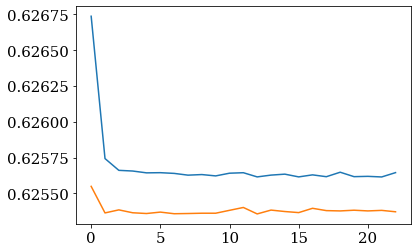

In [27]:
plt.plot( training_hist.history['loss'])
plt.plot( training_hist.history['val_loss'])

In [28]:
w_data = reweight(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval])

10/10 [==============================] - 0s 705us/step


In [29]:
w_data_bgsub_only = w_data

/tmp/ipykernel_2727368/236819712.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


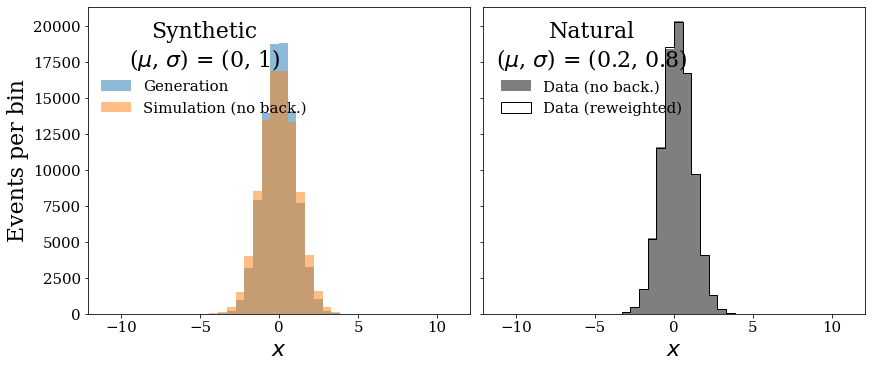

In [30]:
i=0
bins = np.linspace(-11, 11, 41)

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 5),
                       constrained_layout=True,
                       sharey=True)

ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel('Events per bin')
ax[0].hist(theta0_G[theta0_G!=dummyval], bins=bins, **plot_style_2, label='Generation')
ax[0].hist(theta0_S[theta0_S!=dummyval], bins=bins, **plot_style_2, label='Simulation (no back.)')
legend = ax[0].legend(
    title='Synthetic\n($\mu$, $\sigma$) = {}'.format(theta0_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

ax[1].set_xlabel('$x$')
#ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval], bins=bins, **plot_style_2, label='Truth',color="green")
ax[1].hist(theta_unknown_S[theta_unknown_S!=dummyval], bins=bins, **plot_style_2, label='Data (no back.)',color="black")
ax[1].hist(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], bins=bins, histtype="step", label='Data (reweighted)',color="black",weights=w_data)
legend = ax[1].legend(
    title='Natural\n($\mu$, $\sigma$) = {}'.format(theta_unknown_param),
    loc='upper left',
    frameon=False)
plt.setp(legend.get_title(), multialignment='center')

fig.show()
plt.savefig("plot_"+str(i)+"_datareweight.pdf")

In [31]:
model_output_bgsub = model.predict(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], batch_size=10000)

10/10 [==============================] - 0s 712us/step


In [32]:
model_output_bgsub

array([[0.47172025],
       [0.47415447],
       [0.47868657],
       ...,
       [0.47372752],
       [0.45575765],
       [0.47887033]], dtype=float32)

In [33]:
model_output_bgsub.shape

(99844, 1)

In [34]:
squeezed_model_output = np.squeeze(model_output_bgsub)

In [35]:
squeezed_model_output

array([0.47172025, 0.47415447, 0.47868657, ..., 0.47372752, 0.45575765,
       0.47887033], dtype=float32)

In [36]:
squeezed_model_output.shape

(99844,)

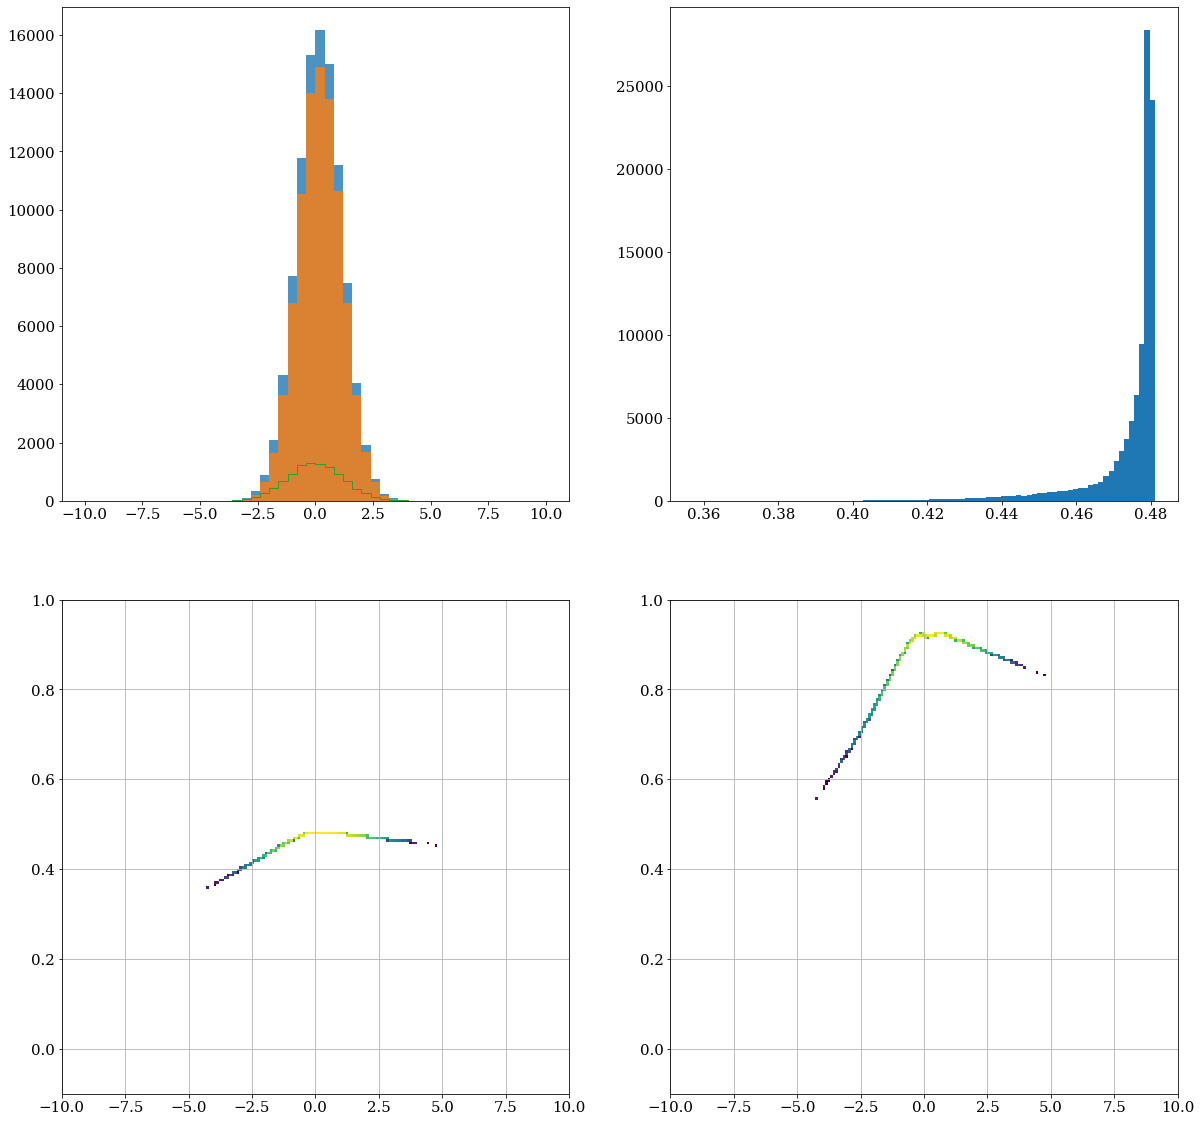

In [37]:
fig,ax = plt.subplots(2,2,figsize=(20,20))



ax[0][0].hist( theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], range=[-10,10], bins=50, alpha=0.8)
ax[0][0].hist( theta_unknown_S[theta_unknown_S!=dummyval], range=[-10,10], bins=50, alpha=0.8)
ax[0][0].hist( theta_background, range=[-10,10], bins=50, histtype="step")

ax[0][1].hist( squeezed_model_output, bins=90 )


ax[1][0].hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         squeezed_model_output,
         density=True,
         bins=200,
         range=([-10,10],[-0.1,1]),
         norm=mpl.colors.LogNorm())
ax[1][0].grid()

ax[1][1].hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         w_data,
         density=True,
         bins=200,
         range=([-10,10],[-0.1,1]),
         norm=mpl.colors.LogNorm())
ax[1][1].grid()

plt.show()

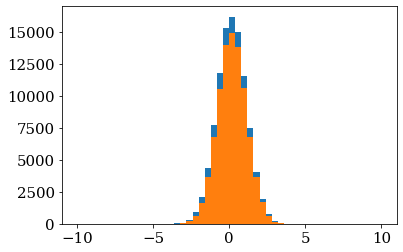

In [38]:
hist_data_all = plt.hist( theta_unknown_S_withback[theta_unknown_S_withback!=dummyval], range=[-10,10], bins=50 )
hist_data_signal = plt.hist( theta_unknown_S[theta_unknown_S!=dummyval], range=[-10,10], bins=50)

In [39]:
hist_data_all

(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        9.0000e+00, 4.1000e+01, 1.0000e+02, 3.3000e+02, 8.9600e+02,
        2.0920e+03, 4.3310e+03, 7.7150e+03, 1.1762e+04, 1.5303e+04,
        1.6167e+04, 1.4988e+04, 1.1551e+04, 7.4710e+03, 4.0480e+03,
        1.9310e+03, 7.5300e+02, 2.4500e+02, 8.8000e+01, 1.9000e+01,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([-10. ,  -9.6,  -9.2,  -8.8,  -8.4,  -8. ,  -7.6,  -7.2,  -6.8,
         -6.4,  -6. ,  -5.6,  -5.2,  -4.8,  -4.4,  -4. ,  -3.6,  -3.2,
         -2.8,  -2.4,  -2. ,  -1.6,  -1.2,  -0.8,  -0.4,   0. ,   0.4,
          0.8,   1.2,   1.6,   2. ,   2.4,   2.8,   3.2,   3.6,   4. ,
          4.4,   4.8,   5.2,   5.6

In [40]:
hist_data_all[0]

array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
       9.0000e+00, 4.1000e+01, 1.0000e+02, 3.3000e+02, 8.9600e+02,
       2.0920e+03, 4.3310e+03, 7.7150e+03, 1.1762e+04, 1.5303e+04,
       1.6167e+04, 1.4988e+04, 1.1551e+04, 7.4710e+03, 4.0480e+03,
       1.9310e+03, 7.5300e+02, 2.4500e+02, 8.8000e+01, 1.9000e+01,
       0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])

In [41]:
hist_axis = hist_data_all[1]

In [42]:
hist_axis

array([-10. ,  -9.6,  -9.2,  -8.8,  -8.4,  -8. ,  -7.6,  -7.2,  -6.8,
        -6.4,  -6. ,  -5.6,  -5.2,  -4.8,  -4.4,  -4. ,  -3.6,  -3.2,
        -2.8,  -2.4,  -2. ,  -1.6,  -1.2,  -0.8,  -0.4,   0. ,   0.4,
         0.8,   1.2,   1.6,   2. ,   2.4,   2.8,   3.2,   3.6,   4. ,
         4.4,   4.8,   5.2,   5.6,   6. ,   6.4,   6.8,   7.2,   7.6,
         8. ,   8.4,   8.8,   9.2,   9.6,  10. ])

In [43]:
hist_axis_centers = np.ones(50)
for i in range(0,50):
    hist_axis_centers[i] = 0.5*(hist_axis[i]+hist_axis[i+1])
    #print(i, hist_axis_centers[i])

In [44]:
signal_frac = (hist_data_signal[0])/(hist_data_all[0])

/tmp/ipykernel_2727368/1092752292.py:1: RuntimeWarning: invalid value encountered in true_divide
  signal_frac = (hist_data_signal[0])/(hist_data_all[0])


In [45]:
signal_frac

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 0.        ,
       0.22222222, 0.2195122 , 0.52      , 0.60606061, 0.7109375 ,
       0.7834608 , 0.84114523, 0.88114064, 0.89466077, 0.91465726,
       0.92175419, 0.92173739, 0.92069951, 0.91045375, 0.90093874,
       0.86380114, 0.83665339, 0.72653061, 0.67045455, 0.42105263,
              nan, 0.        ,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan])

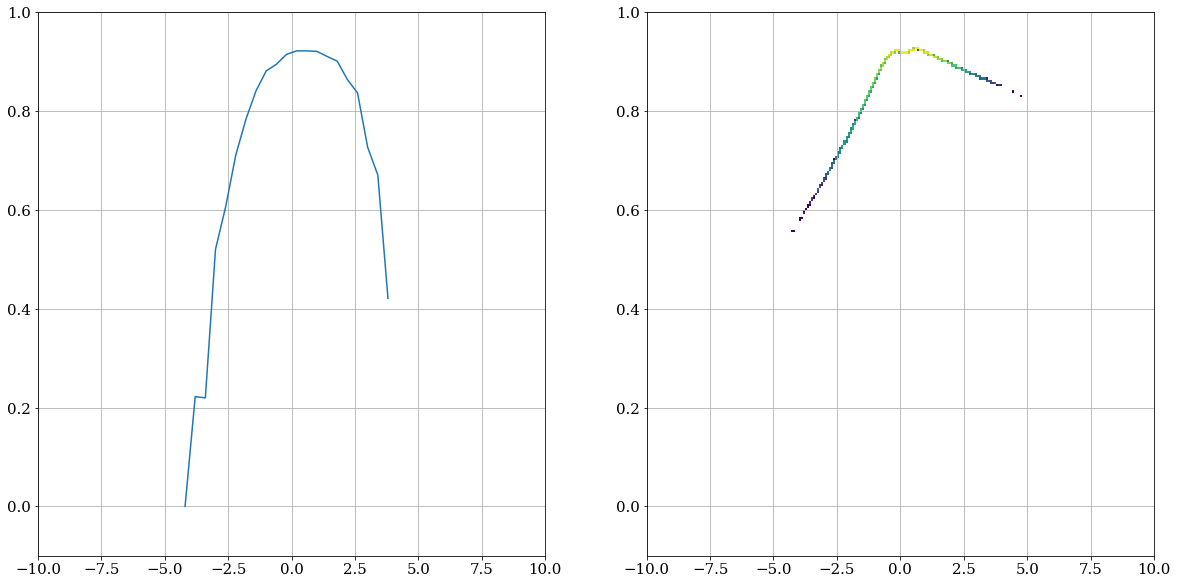

In [46]:
fig,ax = plt.subplots(1,2,figsize=(20,10))


ax[0].plot(hist_axis_centers,signal_frac)
ax[0].set_ylim(-0.1,1)
ax[0].set_xlim(-10,10)
ax[0].grid()

ax[1].hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         w_data_bgsub_only,
         density=True,
         bins=250,
         range=([-10,10],[-0.1,1]),
         norm=mpl.colors.LogNorm())
ax[1].grid()

plt.show()

In [47]:
of_training_history = np.zeros(shape=(4,2,1000))
of_training_history_val = np.zeros(shape=(4,2,1000))


## OmniFold part starts here

In [48]:
# initial iterative weights are ones
weights_pull = np.ones(len(theta0_S))
weights_push = np.ones(len(theta0_S))

In [49]:
xvals_1 = np.concatenate((theta0_S, theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))
yvals_1 = np.concatenate((labels0, np.ones(len(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]))))

In [50]:
%%time

for i in range(iterations):
    print("\n\n\nITERATION: {}\n".format(i + 1))

    
    
    
    
    
    
    # STEP 1: classify Sim. (which is reweighted by weights_push) to Data
    # weights reweighted Sim. --> Data
    print("\n\n\n Iteration %d,  STEP 1, events that pass reco\n\n\n" % (i+1))
    

    weights_1 = np.concatenate((weights_push, w_data))
    #QUESTION: concatenation here confuses me
    # actual weights for Sim., ones for Data (not MC weights)

    X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1) #REMINDER: made up of synthetic+measured

#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])

    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])    
    
    this_hist = model.fit(X_train_1[X_train_1!=dummyval],
              Y_train_1[X_train_1!=dummyval],
              sample_weight=w_train_1[X_train_1!=dummyval],
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_1[X_test_1!=dummyval], Y_test_1[X_test_1!=dummyval], w_test_1[X_test_1!=dummyval]),
              callbacks=[earlystopping],
              verbose=1)

    for ei in range(0,len(this_hist.history['loss'])):
        of_training_history[i,0,ei] = this_hist.history['loss'][ei]
        of_training_history_val[i,0,ei] = this_hist.history['val_loss'][ei]
    
    
    weights_pull = weights_push * reweight(theta0_S) 
    #QUESTION: above model used in reweight function (model.predict)?
    #QUESTION: Model trains until synthetic is indistinguishable from data? How does this work? 
    #How are weights then iteratively multiplied?
 

    ##-- owen: save NN output for each iteration, step.
    nn_output[i,0,:] = np.squeeze(  model.predict(theta0_S, batch_size=10000) )




    print("\n\n\n Iteration %d,  STEP 1, events that do NOT pass reco\n\n\n" % (i+1))

    ###
    #Need to do something with events that don't pass reco.
    
    #One option is to take the prior:
    #weights_pull[theta0_S==dummyval] = 1. 
    
    #Another option is to assign the average weight: <w|x_true>.  To do this, we need to estimate this quantity.
    xvals_1b = np.concatenate([theta0_G[theta0_S!=dummyval],theta0_G[theta0_S!=dummyval]])
    yvals_1b = np.concatenate([np.ones(len(theta0_G[theta0_S!=dummyval])),np.zeros(len(theta0_G[theta0_S!=dummyval]))])
    weights_1b = np.concatenate([weights_pull[theta0_S!=dummyval],np.ones(len(theta0_G[theta0_S!=dummyval]))])
    
    X_train_1b, X_test_1b, Y_train_1b, Y_test_1b, w_train_1b, w_test_1b = train_test_split(
        xvals_1b, yvals_1b, weights_1b)    
    
#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])
    
    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])
    
    
    this_hist = model.fit(X_train_1b,
              Y_train_1b,
              sample_weight=w_train_1b,
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_1b, Y_test_1b, w_test_1b),
              callbacks=[earlystopping],
              verbose=1)


        
        
        
        
        
        
        
    
    
    
    
    average_vals = reweight(theta0_G[theta0_S==dummyval])
    weights_pull[theta0_S==dummyval] = average_vals
    ###
    
    
    ##-- owen: the syntax below is a bit confusing.
    #          it is equivalent to weights[i,0,:] I think.  See Python-syntax-testing notebook.
    weights[i, :1, :] = weights_pull
    
    
    
    
    
    
    
    
    
    
    
    
    

    # STEP 2: classify Gen. to reweighted Gen. (which is reweighted by weights_pull)
    # weights Gen. --> reweighted Gen.
    print("\n\n\n Iteration %d,  STEP 2, events that pass reco\n\n\n" % (i+1))

    weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
    # ones for Gen. (not MC weights), actual weights for (reweighted) Gen.

    X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
        xvals_2, yvals_2, weights_2)

#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])
    

    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])    
    
    this_hist = model.fit(X_train_2,
              Y_train_2,
              sample_weight=w_train_2,
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_2, Y_test_2, w_test_2),
              callbacks=[earlystopping],
              verbose=1)

    for ei in range(0,len(this_hist.history['loss'])):
        of_training_history[i,1,ei] = this_hist.history['loss'][ei]
        of_training_history_val[i,1,ei] = this_hist.history['val_loss'][ei]        
    
    
    
    weights_push = reweight(theta0_G)    
    
    ##-- owen: save NN output for each iteration, step.
    nn_output[i,1,:] = np.squeeze(  model.predict(theta0_G, batch_size=10000) )
    
    
    print("\n\n\n Iteration %d,  STEP 2, events that do NOT pass reco\n\n\n" % (i+1))
    

    ###
    #Need to do something with events that don't pass truth    
    
    #One option is to take the prior:
    #weights_push[theta0_G==dummyval] = 1. 
    
    #Another option is to assign the average weight: <w|x_reco>.  To do this, we need to estimate this quantity.
    xvals_1b = np.concatenate([theta0_S[theta0_G!=dummyval],theta0_S[theta0_G!=dummyval]])
    yvals_1b = np.concatenate([np.ones(len(theta0_S[theta0_G!=dummyval])),np.zeros(len(theta0_S[theta0_G!=dummyval]))])
    weights_1b = np.concatenate([weights_push[theta0_G!=dummyval],np.ones(len(theta0_S[theta0_G!=dummyval]))])
    
    X_train_1b, X_test_1b, Y_train_1b, Y_test_1b, w_train_1b, w_test_1b = train_test_split(
        xvals_1b, yvals_1b, weights_1b)    
    
    
    
#    model.compile(loss='binary_crossentropy',
#                  optimizer='Adam',
#                  metrics=['accuracy'])
    
    model.compile(loss='binary_crossentropy',
                  optimizer=the_optimizer,
                  metrics=['accuracy'],
                  weighted_metrics=[])    

    
    
    model.fit(X_train_1b,
              Y_train_1b,
              sample_weight=w_train_1b,
              epochs=max_epochs,
              batch_size=batch_size_setval,
              validation_data=(X_test_1b, Y_test_1b, w_test_1b),
              callbacks=[earlystopping],
              verbose=1)
    
    average_vals = reweight(theta0_S[theta0_G==dummyval])
    weights_push[theta0_G==dummyval] = average_vals
    ###    

    
    ##-- owen: the syntax below is a bit confusing.
    #          it is equivalent to weights[i,1,:] I think.  See Python-syntax-testing notebook.
    
    weights[i, 1:2, :] = weights_push
    
    
    
    
    
    
    
    
    
    




ITERATION: 1




 Iteration 1,  STEP 1, events that pass reco



Epoch 1/200
15/15 [==============================] - 7s 512ms/step - loss: 0.6517 - accuracy: 0.5134 - val_loss: 0.6491 - val_accuracy: 0.5466
Epoch 2/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6478 - accuracy: 0.5537 - val_loss: 0.6470 - val_accuracy: 0.5563
Epoch 3/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6471 - accuracy: 0.5561 - val_loss: 0.6468 - val_accuracy: 0.5579
Epoch 4/200
15/15 [==============================] - 0s 3ms/step - loss: 0.6469 - accuracy: 0.5567 - val_loss: 0.6468 - val_accuracy: 0.5556
Epoch 5/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6469 - accuracy: 0.5562 - val_loss: 0.6467 - val_accuracy: 0.5546
Epoch 6/200
15/15 [==============================] - 0s 3ms/step - loss: 0.6468 - accuracy: 0.5560 - val_loss: 0.6466 - val_accuracy: 0.5561
Epoch 7/200
15/15 [==============================] - 0s 3ms/step - loss: 0.6467 - ac

Epoch 27/200
14/14 [==============================] - 0s 4ms/step - loss: 0.6860 - accuracy: 0.4981 - val_loss: 0.6856 - val_accuracy: 0.5026
Epoch 28/200
14/14 [==============================] - 0s 4ms/step - loss: 0.6861 - accuracy: 0.4980 - val_loss: 0.6855 - val_accuracy: 0.5027
Epoch 29/200
14/14 [==============================] - 0s 4ms/step - loss: 0.6860 - accuracy: 0.4986 - val_loss: 0.6855 - val_accuracy: 0.5026
Epoch 30/200
14/14 [==============================] - 0s 4ms/step - loss: 0.6860 - accuracy: 0.4986 - val_loss: 0.6857 - val_accuracy: 0.5011
Epoch 31/200
14/14 [==============================] - 0s 4ms/step - loss: 0.6860 - accuracy: 0.4994 - val_loss: 0.6855 - val_accuracy: 0.5034
Epoch 32/200
14/14 [==============================] - 0s 4ms/step - loss: 0.6859 - accuracy: 0.4991 - val_loss: 0.6855 - val_accuracy: 0.5030
Epoch 33/200
14/14 [==============================] - 0s 4ms/step - loss: 0.6860 - accuracy: 0.4990 - val_loss: 0.6855 - val_accuracy: 0.5031
Epoch 

14/14 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.5003 - val_loss: 0.6927 - val_accuracy: 0.4999
Epoch 3/200
14/14 [==============================] - 0s 4ms/step - loss: 0.6928 - accuracy: 0.4995 - val_loss: 0.6925 - val_accuracy: 0.5017
Epoch 4/200
14/14 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.4998 - val_loss: 0.6924 - val_accuracy: 0.5006
Epoch 5/200
14/14 [==============================] - 0s 3ms/step - loss: 0.6928 - accuracy: 0.4994 - val_loss: 0.6925 - val_accuracy: 0.4998
Epoch 6/200
14/14 [==============================] - 0s 4ms/step - loss: 0.6926 - accuracy: 0.5001 - val_loss: 0.6924 - val_accuracy: 0.5007
Epoch 7/200
14/14 [==============================] - 0s 3ms/step - loss: 0.6927 - accuracy: 0.5002 - val_loss: 0.6924 - val_accuracy: 0.5008
Epoch 8/200
14/14 [==============================] - 0s 4ms/step - loss: 0.6927 - accuracy: 0.5000 - val_loss: 0.6925 - val_accuracy: 0.5006
Epoch 9/200
14/14 [======

14/14 [==============================] - 0s 4ms/step - loss: 0.6795 - accuracy: 0.4999 - val_loss: 0.6795 - val_accuracy: 0.5016
Epoch 30/200
14/14 [==============================] - 0s 4ms/step - loss: 0.6795 - accuracy: 0.4989 - val_loss: 0.6795 - val_accuracy: 0.5014
Epoch 31/200
14/14 [==============================] - 0s 4ms/step - loss: 0.6795 - accuracy: 0.4987 - val_loss: 0.6796 - val_accuracy: 0.5012
Epoch 32/200
14/14 [==============================] - 0s 4ms/step - loss: 0.6796 - accuracy: 0.4997 - val_loss: 0.6794 - val_accuracy: 0.5021
Epoch 33/200
14/14 [==============================] - 0s 4ms/step - loss: 0.6795 - accuracy: 0.4991 - val_loss: 0.6795 - val_accuracy: 0.5019
Epoch 34/200
14/14 [==============================] - 0s 4ms/step - loss: 0.6795 - accuracy: 0.4993 - val_loss: 0.6795 - val_accuracy: 0.5016
Epoch 35/200
14/14 [==============================] - 0s 4ms/step - loss: 0.6795 - accuracy: 0.4990 - val_loss: 0.6795 - val_accuracy: 0.5016
Epoch 36/200
14/14 

15/15 [==============================] - 0s 4ms/step - loss: 0.6539 - accuracy: 0.5519 - val_loss: 0.6525 - val_accuracy: 0.5485
Epoch 4/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6538 - accuracy: 0.5446 - val_loss: 0.6525 - val_accuracy: 0.5482
Epoch 5/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6538 - accuracy: 0.5424 - val_loss: 0.6526 - val_accuracy: 0.5312
Epoch 6/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6539 - accuracy: 0.5395 - val_loss: 0.6526 - val_accuracy: 0.5551
Epoch 7/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6538 - accuracy: 0.5409 - val_loss: 0.6525 - val_accuracy: 0.5461
Epoch 8/200
15/15 [==============================] - 0s 3ms/step - loss: 0.6538 - accuracy: 0.5535 - val_loss: 0.6525 - val_accuracy: 0.5418
Epoch 9/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6538 - accuracy: 0.5470 - val_loss: 0.6526 - val_accuracy: 0.5340
Epoch 10/200
15/15 [=====

15/15 [==============================] - 0s 3ms/step - loss: 0.6789 - accuracy: 0.5006 - val_loss: 0.6778 - val_accuracy: 0.4980
Epoch 7/200
15/15 [==============================] - 0s 3ms/step - loss: 0.6788 - accuracy: 0.5013 - val_loss: 0.6777 - val_accuracy: 0.4976
Epoch 8/200
15/15 [==============================] - 0s 3ms/step - loss: 0.6789 - accuracy: 0.5007 - val_loss: 0.6778 - val_accuracy: 0.4981
Epoch 9/200
15/15 [==============================] - 0s 3ms/step - loss: 0.6787 - accuracy: 0.5005 - val_loss: 0.6776 - val_accuracy: 0.4988
Epoch 10/200
15/15 [==============================] - 0s 3ms/step - loss: 0.6788 - accuracy: 0.5008 - val_loss: 0.6777 - val_accuracy: 0.4988
Epoch 11/200
15/15 [==============================] - 0s 3ms/step - loss: 0.6787 - accuracy: 0.5010 - val_loss: 0.6777 - val_accuracy: 0.4989
Epoch 12/200
15/15 [==============================] - 0s 3ms/step - loss: 0.6787 - accuracy: 0.5002 - val_loss: 0.6776 - val_accuracy: 0.4984
Epoch 13/200
15/15 [==

15/15 [==============================] - 0s 3ms/step - loss: 0.6529 - accuracy: 0.5542 - val_loss: 0.6526 - val_accuracy: 0.5524
Epoch 24/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6529 - accuracy: 0.5523 - val_loss: 0.6526 - val_accuracy: 0.5508
Epoch 25/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6529 - accuracy: 0.5522 - val_loss: 0.6526 - val_accuracy: 0.5512
Epoch 26/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6529 - accuracy: 0.5562 - val_loss: 0.6526 - val_accuracy: 0.5588
Epoch 27/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6529 - accuracy: 0.5532 - val_loss: 0.6527 - val_accuracy: 0.5054
Epoch 28/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6529 - accuracy: 0.5372 - val_loss: 0.6526 - val_accuracy: 0.5560
Epoch 29/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6529 - accuracy: 0.5559 - val_loss: 0.6526 - val_accuracy: 0.5574
Epoch 29: early sto

14/14 [==============================] - 0s 4ms/step - loss: 0.6834 - accuracy: 0.4995 - val_loss: 0.6843 - val_accuracy: 0.4991
Epoch 18/200
14/14 [==============================] - 0s 4ms/step - loss: 0.6834 - accuracy: 0.5002 - val_loss: 0.6843 - val_accuracy: 0.4989
Epoch 19/200
14/14 [==============================] - 0s 4ms/step - loss: 0.6834 - accuracy: 0.5002 - val_loss: 0.6843 - val_accuracy: 0.4990
Epoch 20/200
14/14 [==============================] - 0s 4ms/step - loss: 0.6834 - accuracy: 0.4992 - val_loss: 0.6844 - val_accuracy: 0.4990
Epoch 21/200
14/14 [==============================] - 0s 4ms/step - loss: 0.6834 - accuracy: 0.5007 - val_loss: 0.6843 - val_accuracy: 0.4994
Epoch 22/200
14/14 [==============================] - 0s 4ms/step - loss: 0.6834 - accuracy: 0.5000 - val_loss: 0.6843 - val_accuracy: 0.4991
Epoch 22: early stopping
1/1 [==============================] - 0s 42ms/step
CPU times: user 8min 32s, sys: 4.61 s, total: 8min 36s
Wall time: 8min 20s


ITERATION 1:
ITERATION 2:
ITERATION 3:
ITERATION 4:


<Figure size 864x360 with 0 Axes>

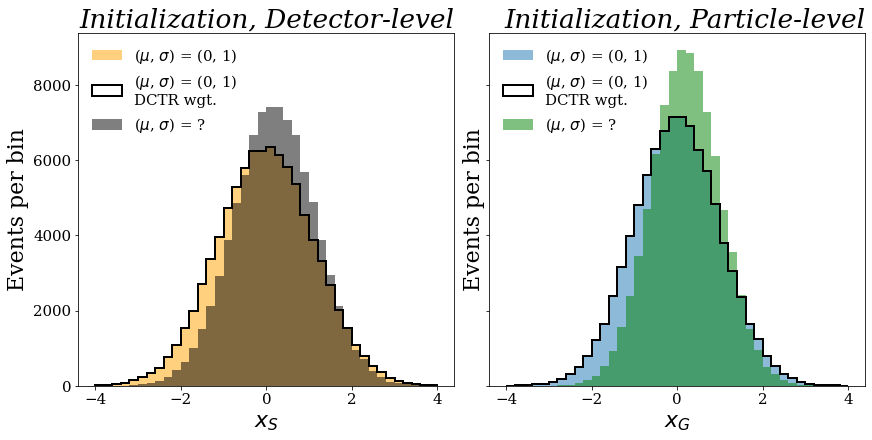

<Figure size 864x360 with 0 Axes>

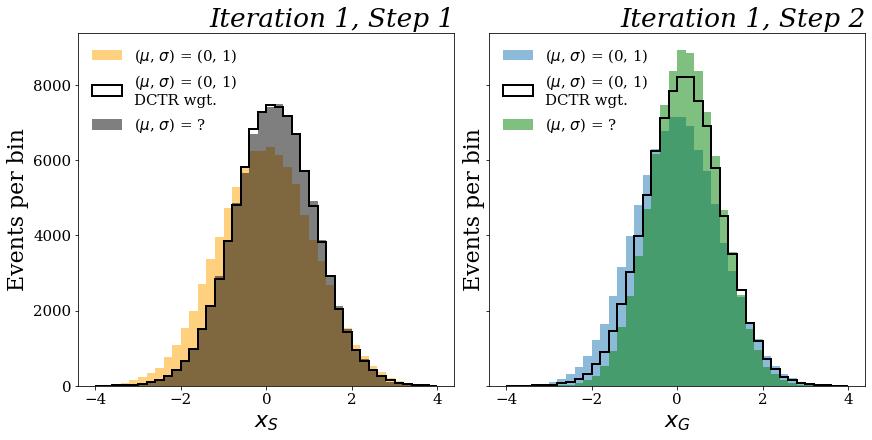

<Figure size 864x360 with 0 Axes>

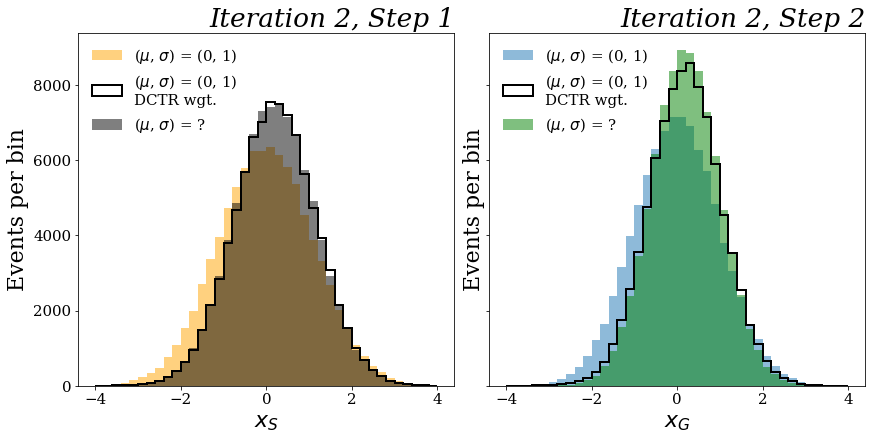

<Figure size 864x360 with 0 Axes>

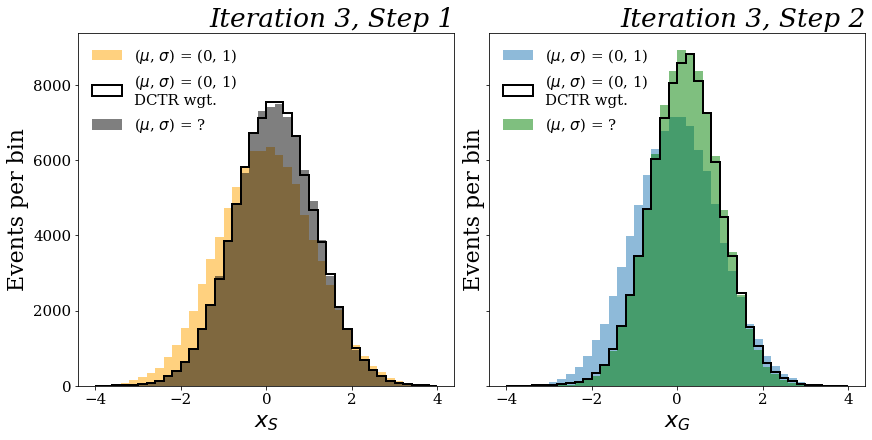

<Figure size 864x360 with 0 Axes>

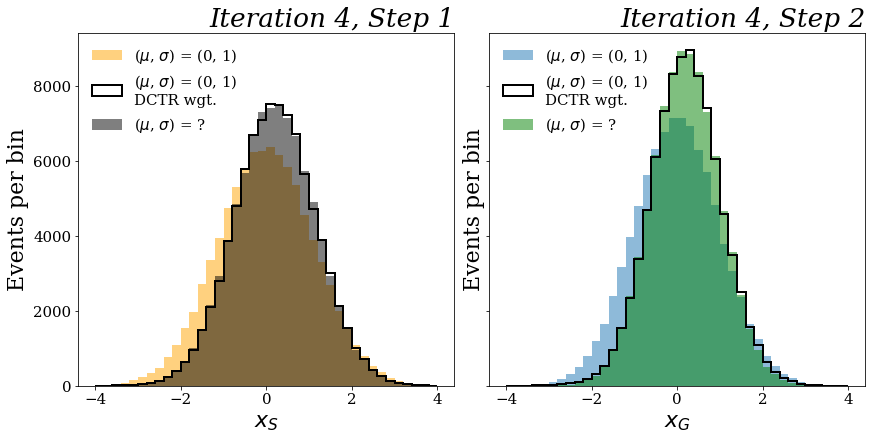

In [51]:
bins = np.linspace(-4, 4, 41)

plt.figure(figsize=(12, 5))

fig, ax = plt.subplots(1,
                       2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)

#Detector-level
ax[0].set_title("Initialization, Detector-level",style='italic',loc='right')
hist0 = ax[0].hist(theta0_S[theta0_S!=dummyval],
                 bins=bins,
                 color="orange",
                 label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                 **plot_style_2)

_,_,_= ax[0].hist(
    theta0_S[theta0_S!=0],
    bins=bins,
    label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
    **plot_style_1)
_,_,_= ax[0].hist(theta_unknown_S[theta_unknown_S!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = ?',
                 weights=weights[i, 0, :][theta_unknown_S!=dummyval],
                 **plot_style_2,
                color="black")
ax[0].legend(frameon=False)
ax[0].set_xlabel(r"$x_S$")
ax[0].set_ylabel("Events per bin")

#Particle-level
ax[1].set_title("Initialization, Particle-level",style='italic',loc='right')
_,_,_=ax[1].hist(theta0_G[theta0_G!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                 **plot_style_2)

_,_,_= ax[1].hist(
    theta0_G[theta0_G!=0],
    bins=bins,
    label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
    **plot_style_1)
_,_,_= ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval],
                 bins=bins,
                 label=r'($\mu$, $\sigma$) = ?',
                 **plot_style_2,
                color="green")
ax[1].legend(frameon=False)
ax[1].set_xlabel(r"$x_G$")
ax[1].set_ylabel("Events per bin")

plt.savefig("plot_0.pdf")

#Iterations
for i in range(iterations):
    print("ITERATION {}:".format(i + 1))
    plt.figure(figsize=(12, 5))
    
    fig, ax = plt.subplots(1,2,
                       figsize=(12, 6),
                       constrained_layout=True,
                       sharey=True)
    
    #Detector-level
    ax[0].set_title("Iteration " +str(i+1)+ ", Step 1",style='italic',loc='right')
    _,_,_ = ax[0].hist(theta0_S[theta0_S!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                     color="orange",
                     **plot_style_2)

    _,_,_ = ax[0].hist(
        theta0_S[theta0_S!=dummyval],
        bins=bins,
        label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
        weights=weights[i, 0, :][theta0_S!=dummyval],
        **plot_style_1)
    _,_,_ = ax[0].hist(theta_unknown_S[theta_unknown_S!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = ?',
                     **plot_style_2,
                    color="black")
    ax[0].legend(frameon=False)
    ax[0].set_xlabel(r"$x_S$")
    ax[0].set_ylabel("Events per bin")
    
    #Particle-level
    ax[1].set_title("Iteration " +str(i+1)+ ", Step 2",style='italic',loc='right')
    _,_,_ = ax[1].hist(theta0_G[theta0_G!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = {}'.format(theta0_param),
                     **plot_style_2)

    _,_,_ = ax[1].hist(
        theta0_G[theta0_G!=dummyval],
        bins=bins,
        label='($\mu$, $\sigma$) = {}\nDCTR wgt.'.format(theta0_param),
        weights=weights[i, 1, :][theta0_G!=dummyval],
        **plot_style_1)
    _,_,_ = ax[1].hist(theta_unknown_G[theta_unknown_G!=dummyval],
                     bins=bins,
                     label=r'($\mu$, $\sigma$) = ?',
                     **plot_style_2,
                    color="green")
    ax[1].legend(frameon=False)
    ax[1].set_xlabel(r"$x_G$")
    ax[1].set_ylabel("Events per bin")
    
    plt.savefig("plot_"+str(i+1)+".pdf")

## Owen: inspecting a few things after running everything

In [52]:
weights

array([[[1.20474231, 0.63094276, 1.16748393, ..., 1.16176915,
         1.17010558, 1.20951176],
        [1.20257759, 0.78170896, 1.1427114 , ..., 1.20898926,
         1.06717873, 0.86182606]],

       [[1.23610973, 0.63387859, 1.19758582, ..., 1.24505746,
         1.10737073, 0.91738856],
        [1.22131574, 0.69703251, 1.16496968, ..., 1.26928425,
         1.05622065, 0.78375292]],

       [[1.24271214, 0.64600235, 1.21582437, ..., 1.32482624,
         1.1017406 , 0.82073414],
        [1.23397696, 0.64948207, 1.19443548, ..., 1.29564524,
         1.07095933, 0.77225733]],

       [[1.26431143, 0.61636668, 1.22461021, ..., 1.33004689,
         1.0983417 , 0.78656656],
        [1.2586174 , 0.64351839, 1.22219551, ..., 1.31568849,
         1.09929848, 0.76708263]]])

In [53]:
weights.shape

(4, 2, 100000)

In [54]:
Input

<function keras.engine.input_layer.Input(shape=None, batch_size=None, name=None, dtype=None, sparse=None, tensor=None, ragged=None, type_spec=None, **kwargs)>

In [55]:
Model

keras.engine.training.Model

In [56]:
x_data_and_MCback

array([ 0.73533029,  3.16051069, -0.17889018, ..., -0.61583193,
       -1.22851978,  0.18574865])

In [57]:
x_data_and_MCback.shape

(209688,)

In [58]:
y_data_and_MCback

array([1., 1., 1., ..., 0., 0., 0.])

In [59]:
y_data_and_MCback.shape

(209688,)

In [60]:
W_data_and_MCback

array([-1., -1., -1., ...,  1.,  1.,  1.])

In [61]:
W_data_and_MCback.shape

(209688,)

In [62]:
w_data

array([0.8929364 , 0.9016992 , 0.9182318 , ..., 0.9001564 , 0.83741665,
       0.91890824], dtype=float32)

In [63]:
w_data.shape

(99844,)

In [64]:
theta_unknown_S_withback[theta_unknown_S_withback!=dummyval]

array([-0.69937094, -0.59717678, -0.30284565, ..., -0.61583193,
       -1.22851978,  0.18574865])

In [65]:
theta_unknown_S_withback[theta_unknown_S_withback!=dummyval].shape

(99844,)

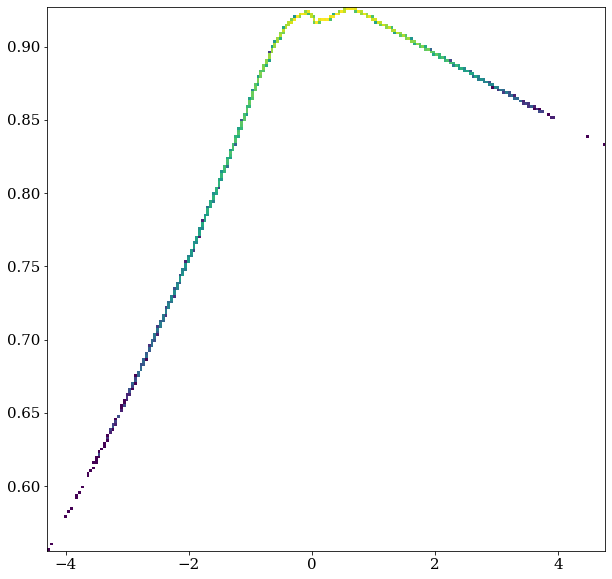

In [66]:
fig,ax = plt.subplots(1,1,figsize=(10,10))

ax.hist2d(theta_unknown_S_withback[theta_unknown_S_withback!=dummyval],
         w_data,
         density=True,
         bins=200,
         norm=mpl.colors.LogNorm())

plt.show()

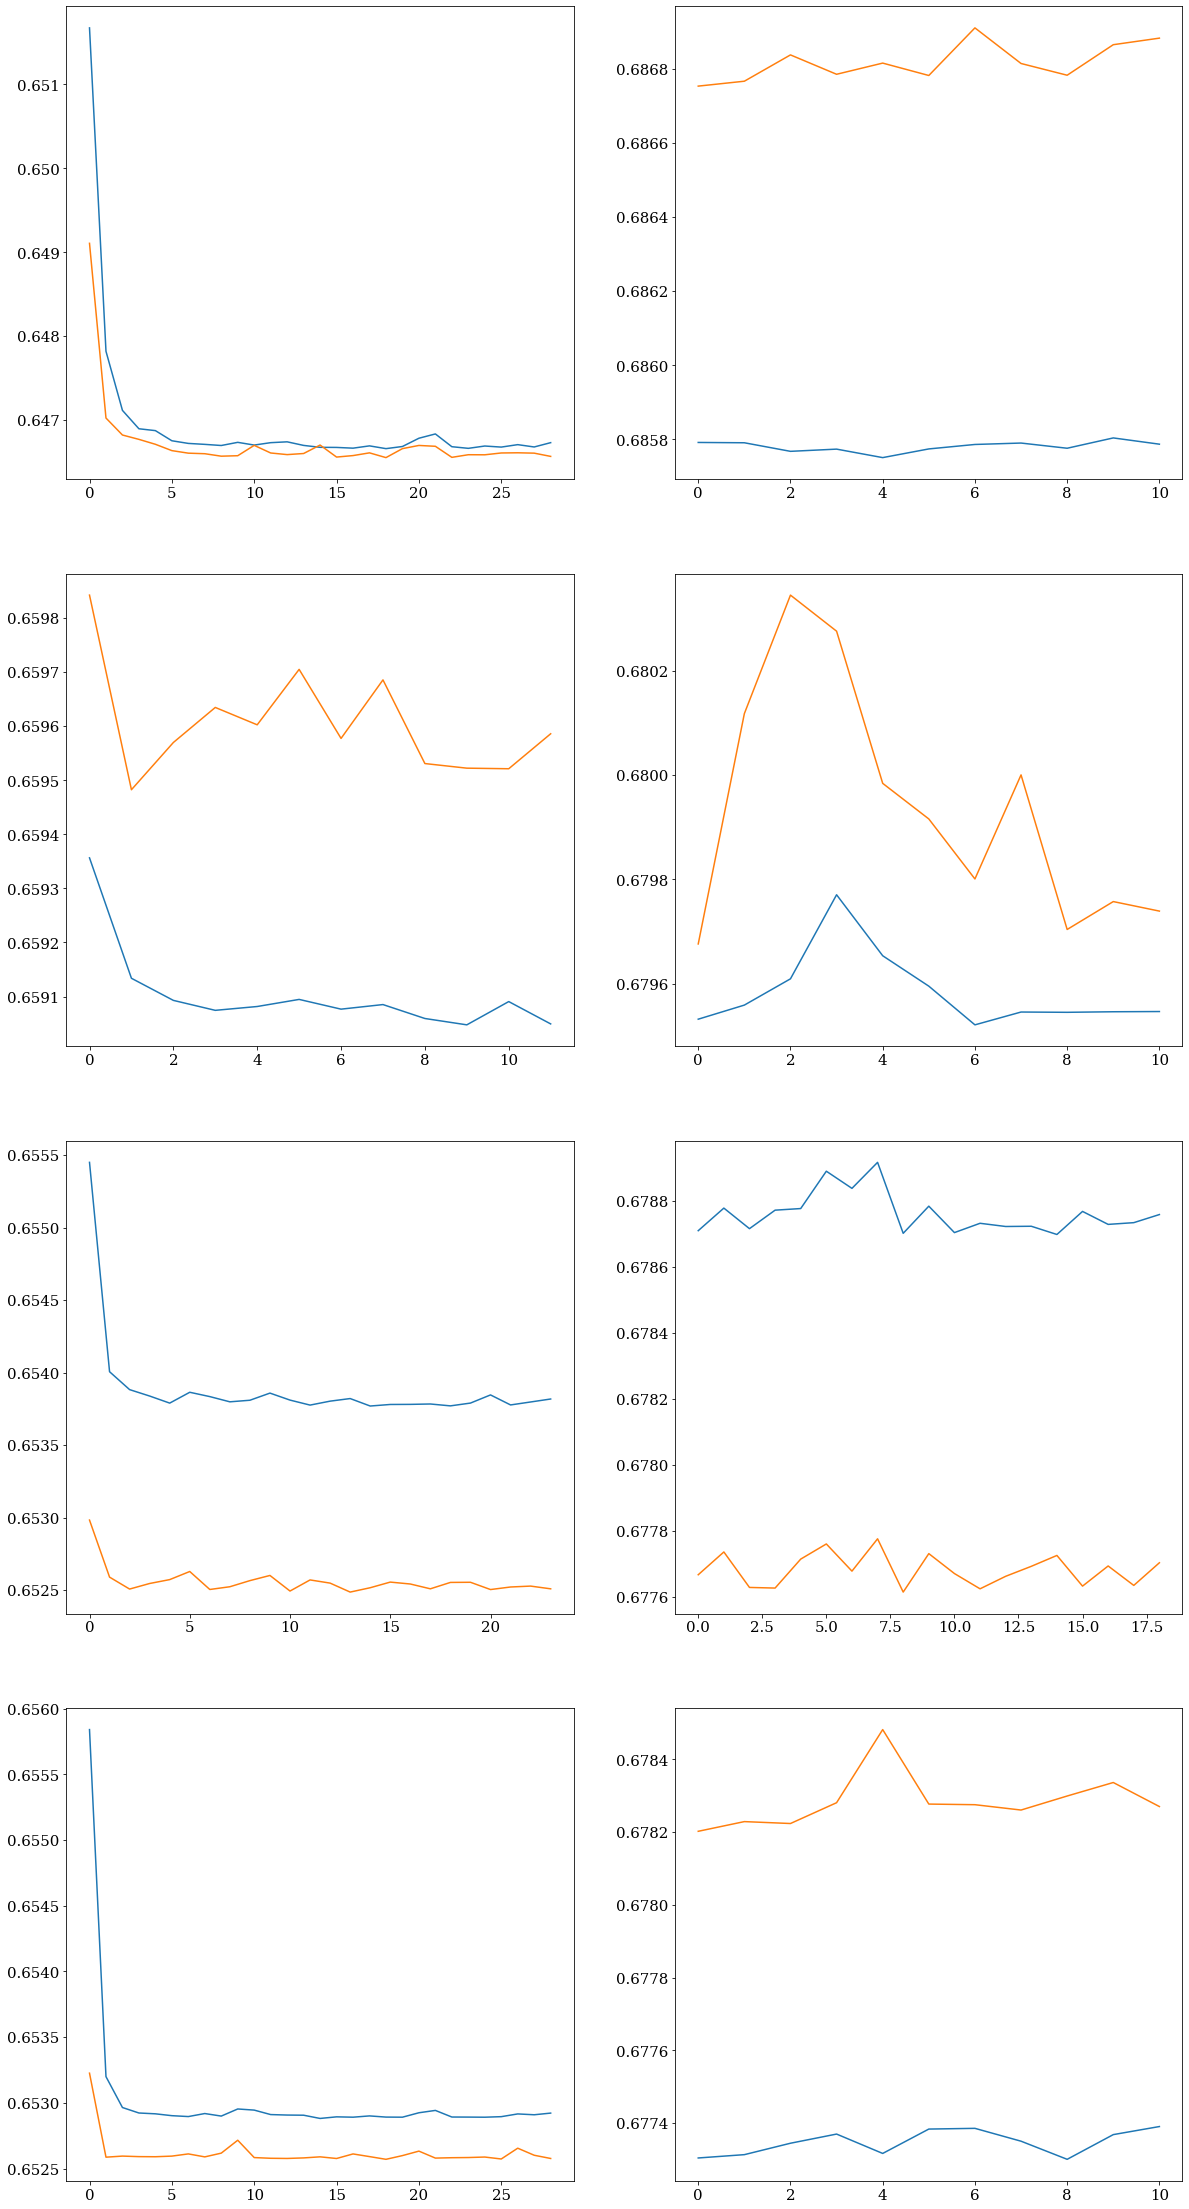

In [67]:
fig,ax = plt.subplots(4,2,figsize=(20,40))

for i in range(0,4):
    
    ax[i][0].plot( of_training_history[i][0][of_training_history[i][0]>0] )
    ax[i][0].plot( of_training_history_val[i][0][of_training_history[i][0]>0] )
    
    ax[i][1].plot( of_training_history[i][1][of_training_history[i][1]>0] )
    ax[i][1].plot( of_training_history_val[i][1][of_training_history[i][1]>0] )    
    
plt.show()

## distributions of weights

### Weights on full simulation to match data (step1)

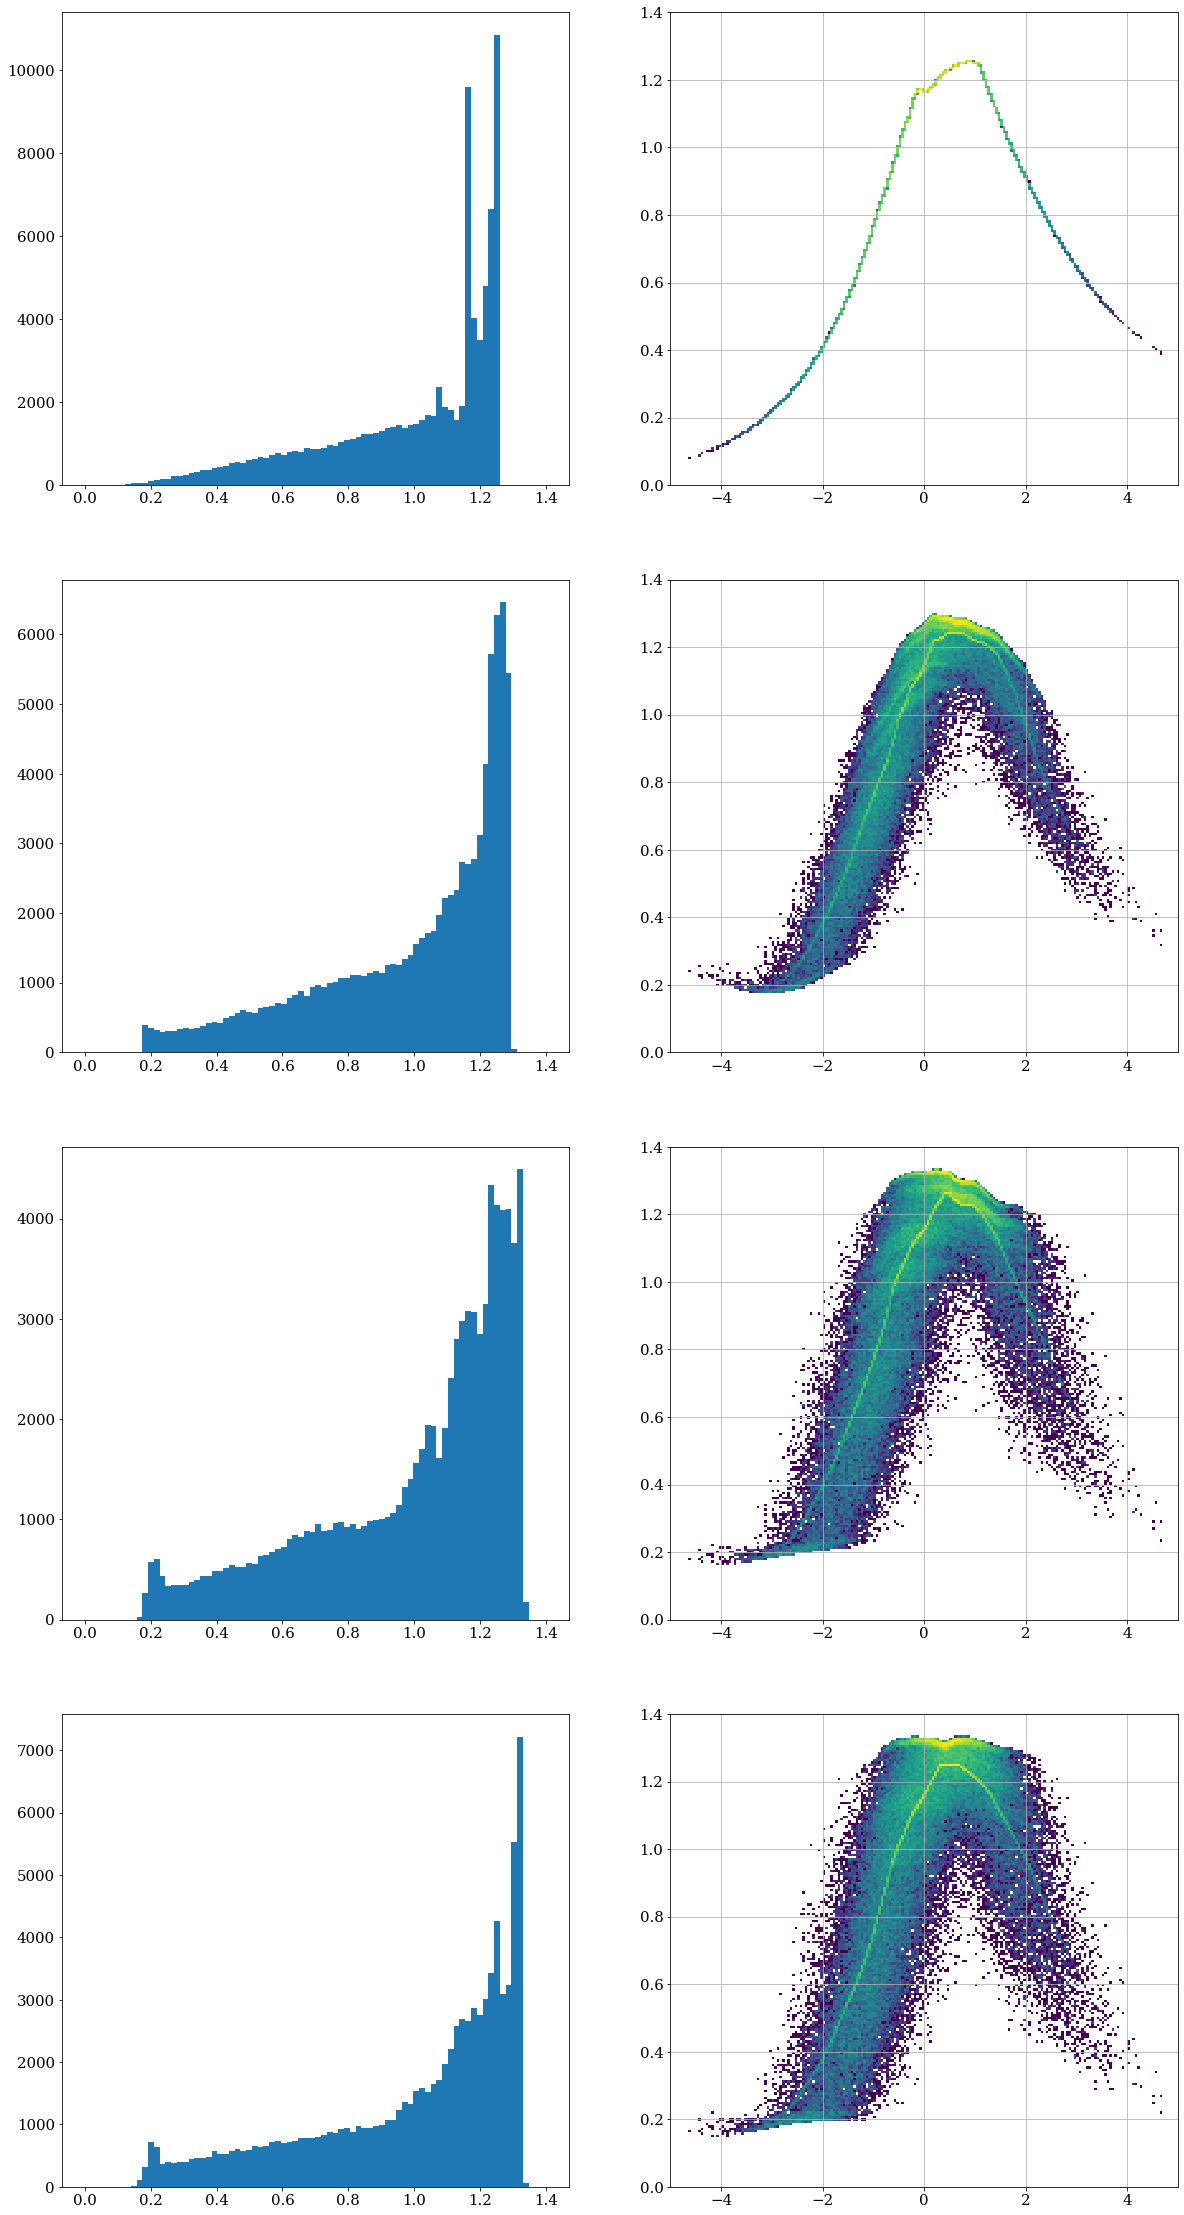

In [68]:
fig,ax = plt.subplots(iterations,2,figsize=(20,40))

for i in range(0,iterations):
    
    ax[i][0].hist( weights[i,0,theta0_S!=dummyval], bins=80, range=[0,1.4] )
    
    ax[i][1].hist2d( theta0_S[theta0_S!=dummyval], weights[i,0,theta0_S!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[0,1.4]))
    ax[i][1].grid()
    
plt.show()

### Weights on gen (step2)

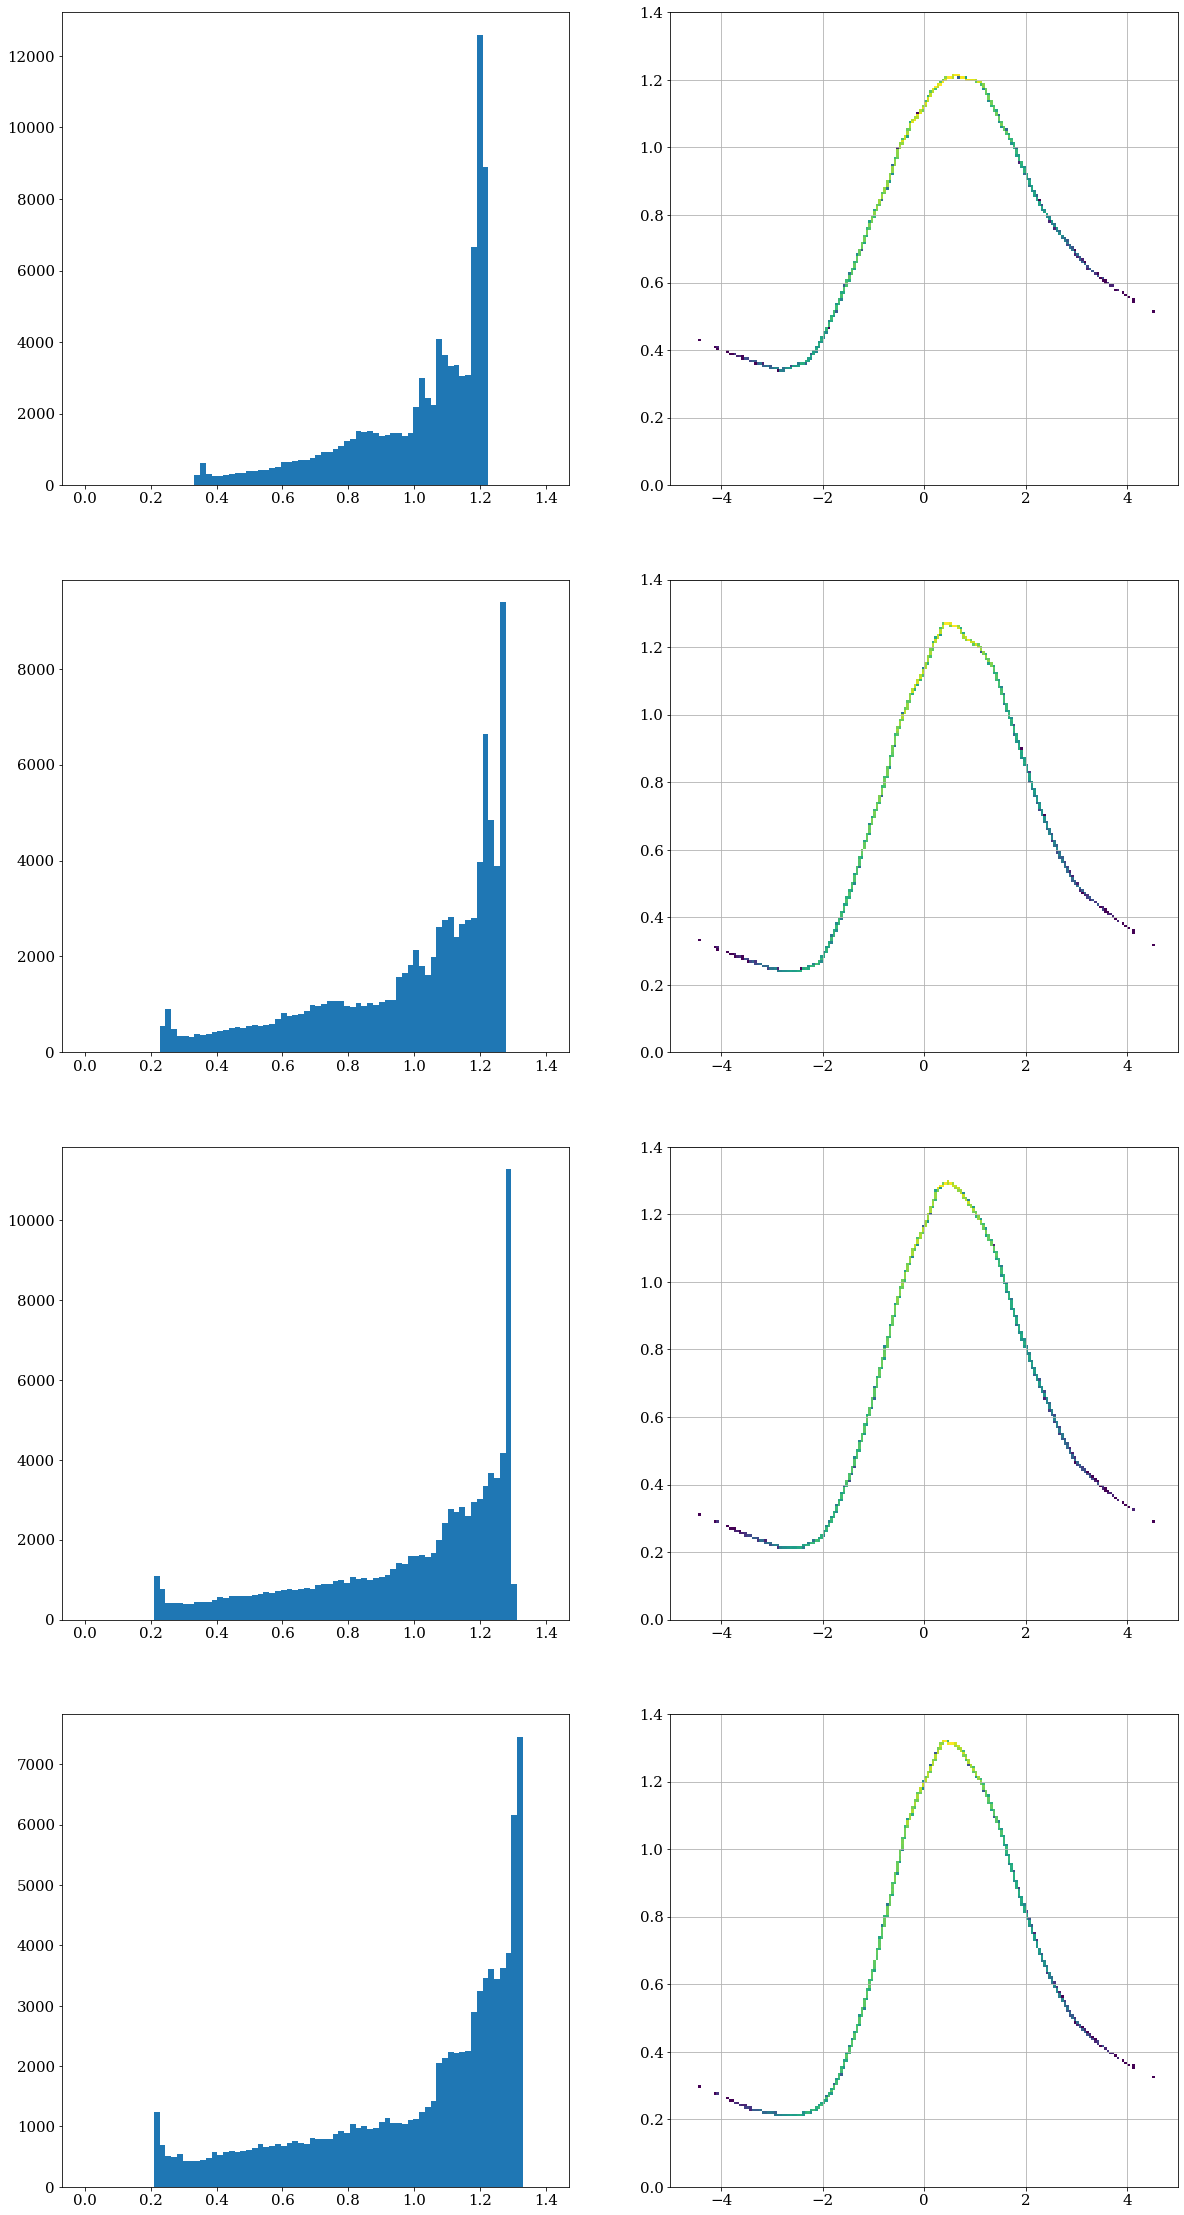

In [69]:
fig,ax = plt.subplots(iterations,2,figsize=(20,40))

for i in range(0,iterations):
    
    ax[i][0].hist( weights[i,1,theta0_G!=dummyval], bins=80, range=[0,1.4] )
    
    ax[i][1].hist2d( theta0_G[theta0_G!=dummyval], weights[i,1,theta0_G!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[0,1.4]))
    ax[i][1].grid()
    
plt.show()

## Change in weights on fullsim (step1) between consecutive iterations

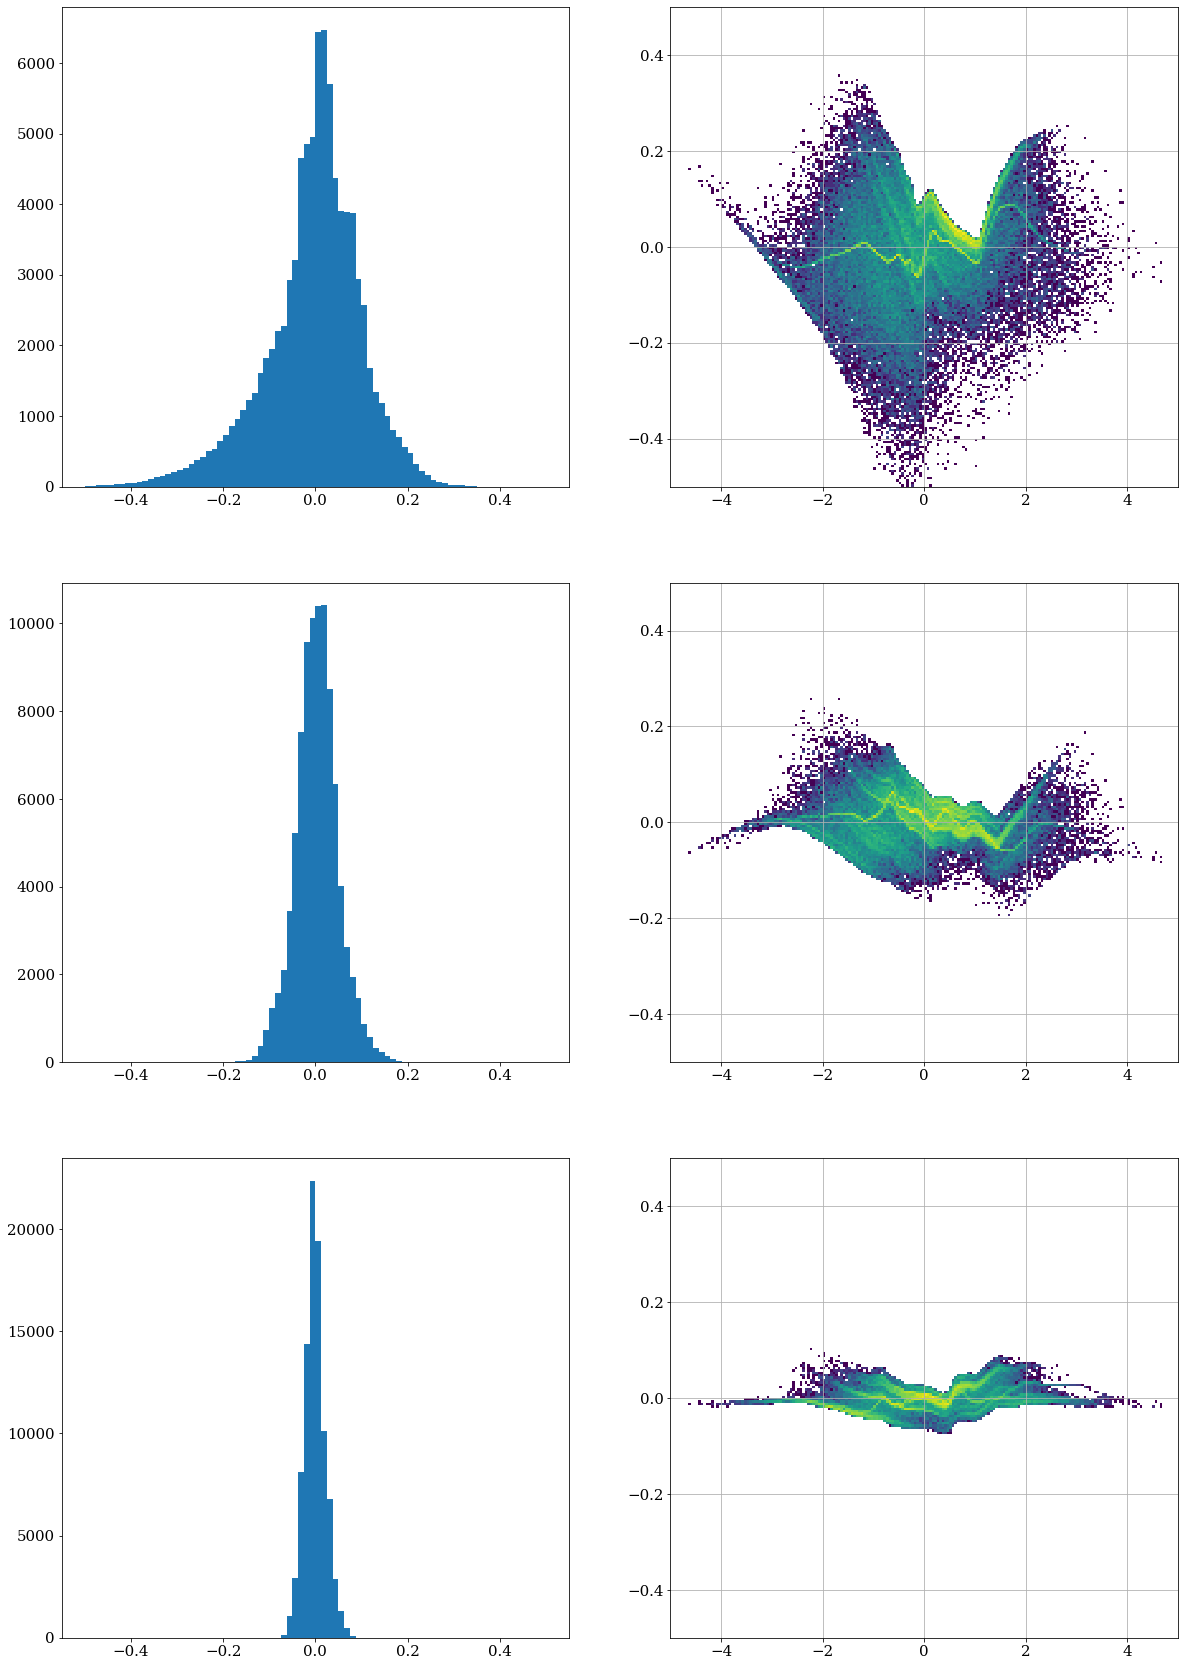

In [70]:
fig,ax = plt.subplots(iterations-1,2,figsize=(20,30))

for i in range(0,iterations-1):
    
    ax[i][0].hist( weights[i+1,0,theta0_S!=dummyval]-weights[i,0,theta0_S!=dummyval], bins=80,
                 range=[-0.5,0.5])
    
    ax[i][1].hist2d( theta0_S[theta0_S!=dummyval], weights[i+1,0,theta0_S!=dummyval]-weights[i,0,theta0_S!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[-0.5,0.5]))
    ax[i][1].grid()
    
plt.show()

## Change in weights on gen (step2) between consecutive iterations

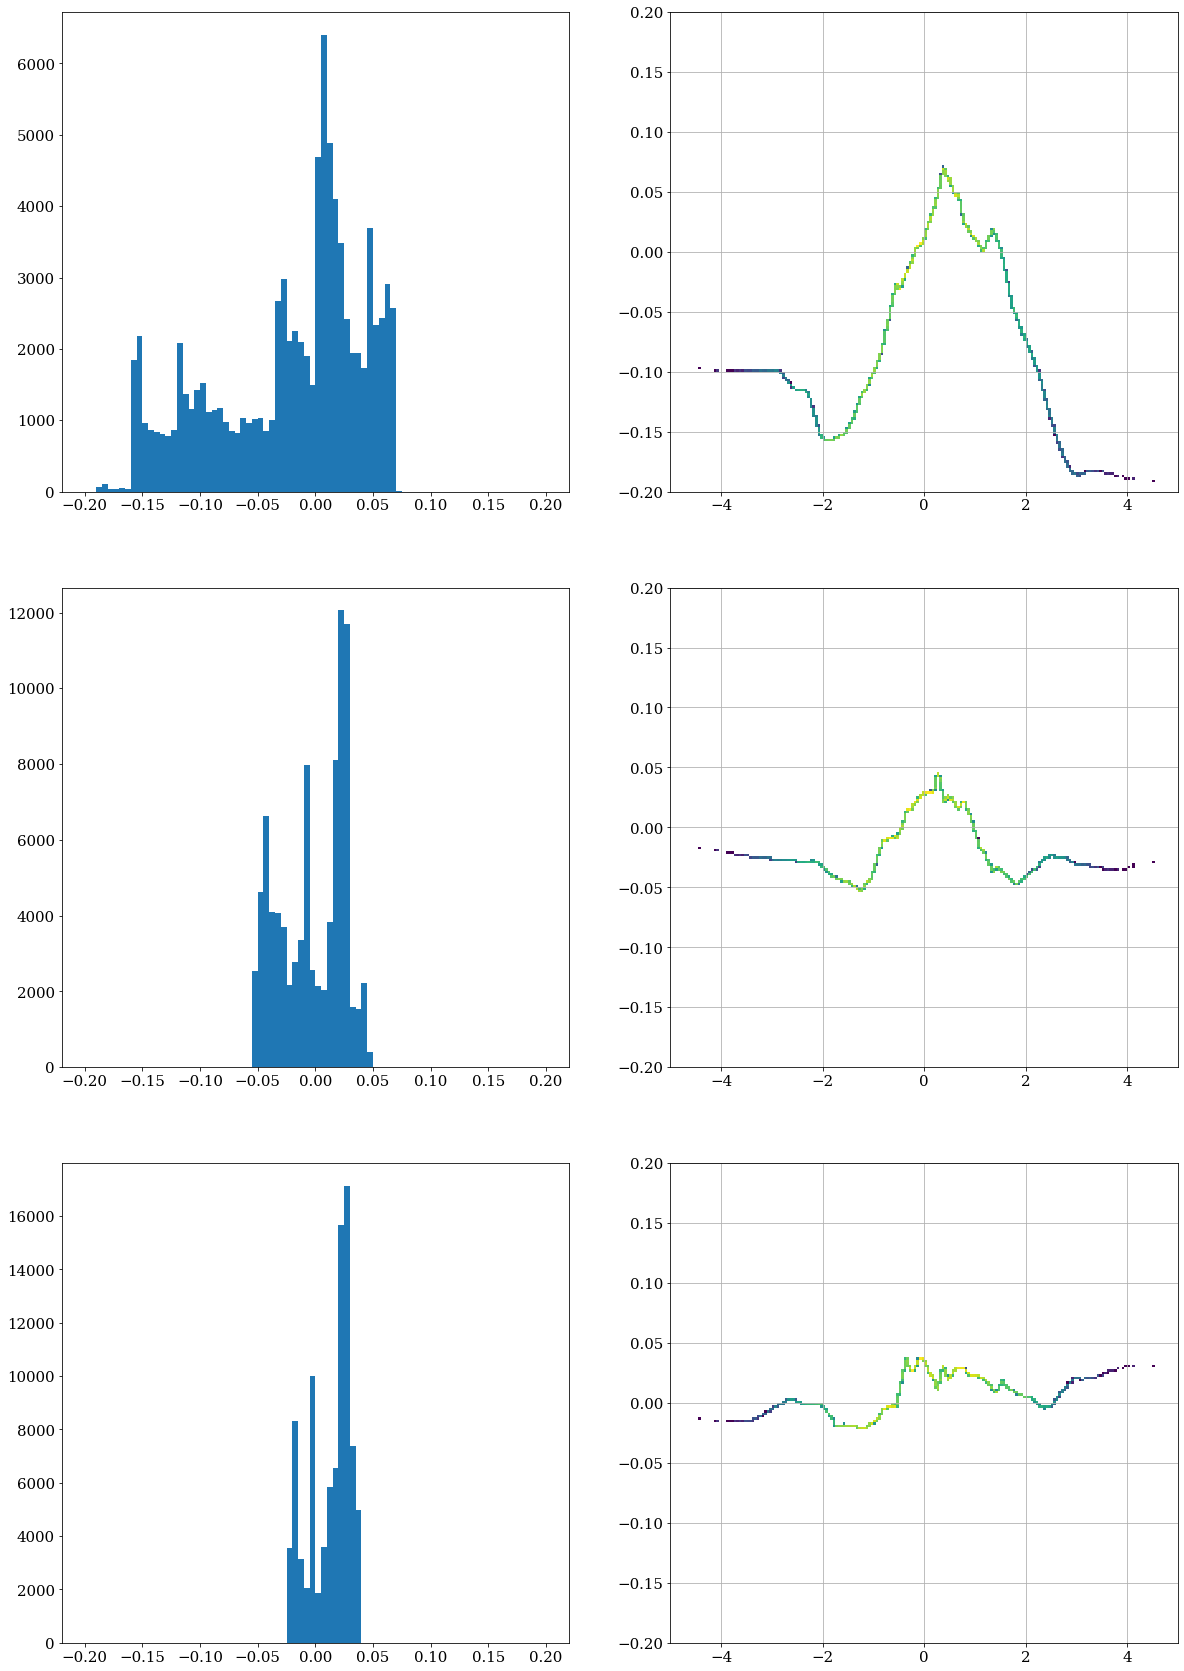

In [71]:
fig,ax = plt.subplots(iterations-1,2,figsize=(20,30))

for i in range(0,iterations-1):
    
    ax[i][0].hist( weights[i+1,1,theta0_G!=dummyval]-weights[i,1,theta0_G!=dummyval], bins=80,
                 range=[-0.2,0.2])
    
    ax[i][1].hist2d( theta0_G[theta0_G!=dummyval], weights[i+1,1,theta0_G!=dummyval]-weights[i,1,theta0_G!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[-0.2,0.2]))
    ax[i][1].grid()
    
plt.show()

In [72]:
nn_output

array([[[0.00298362, 0.38685769, 0.53863555, ..., 0.53741592,
         0.53919291, 0.54741132],
        [0.54598647, 0.49092138, 0.53330159, ..., 0.54730427,
         0.51624888, 0.46289289]],

       [[0.66140807, 0.44778481, 0.51172382, ..., 0.50734872,
         0.50924146, 0.51561433],
        [0.54981637, 0.49418241, 0.53809977, ..., 0.55933243,
         0.51367086, 0.43938425]],

       [[0.56440127, 0.48100191, 0.5106802 , ..., 0.51070541,
         0.51054698, 0.51152432],
        [0.55236781, 0.50008434, 0.54430193, ..., 0.56439263,
         0.51713198, 0.43574786]],

       [[0.53473985, 0.4869197 , 0.50623691, ..., 0.50655097,
         0.50631136, 0.50458974],
        [0.55725127, 0.49113855, 0.54999459, ..., 0.56816298,
         0.52365041, 0.4340955 ]]])

## Output of NN for step1: distinguish data from fullsim

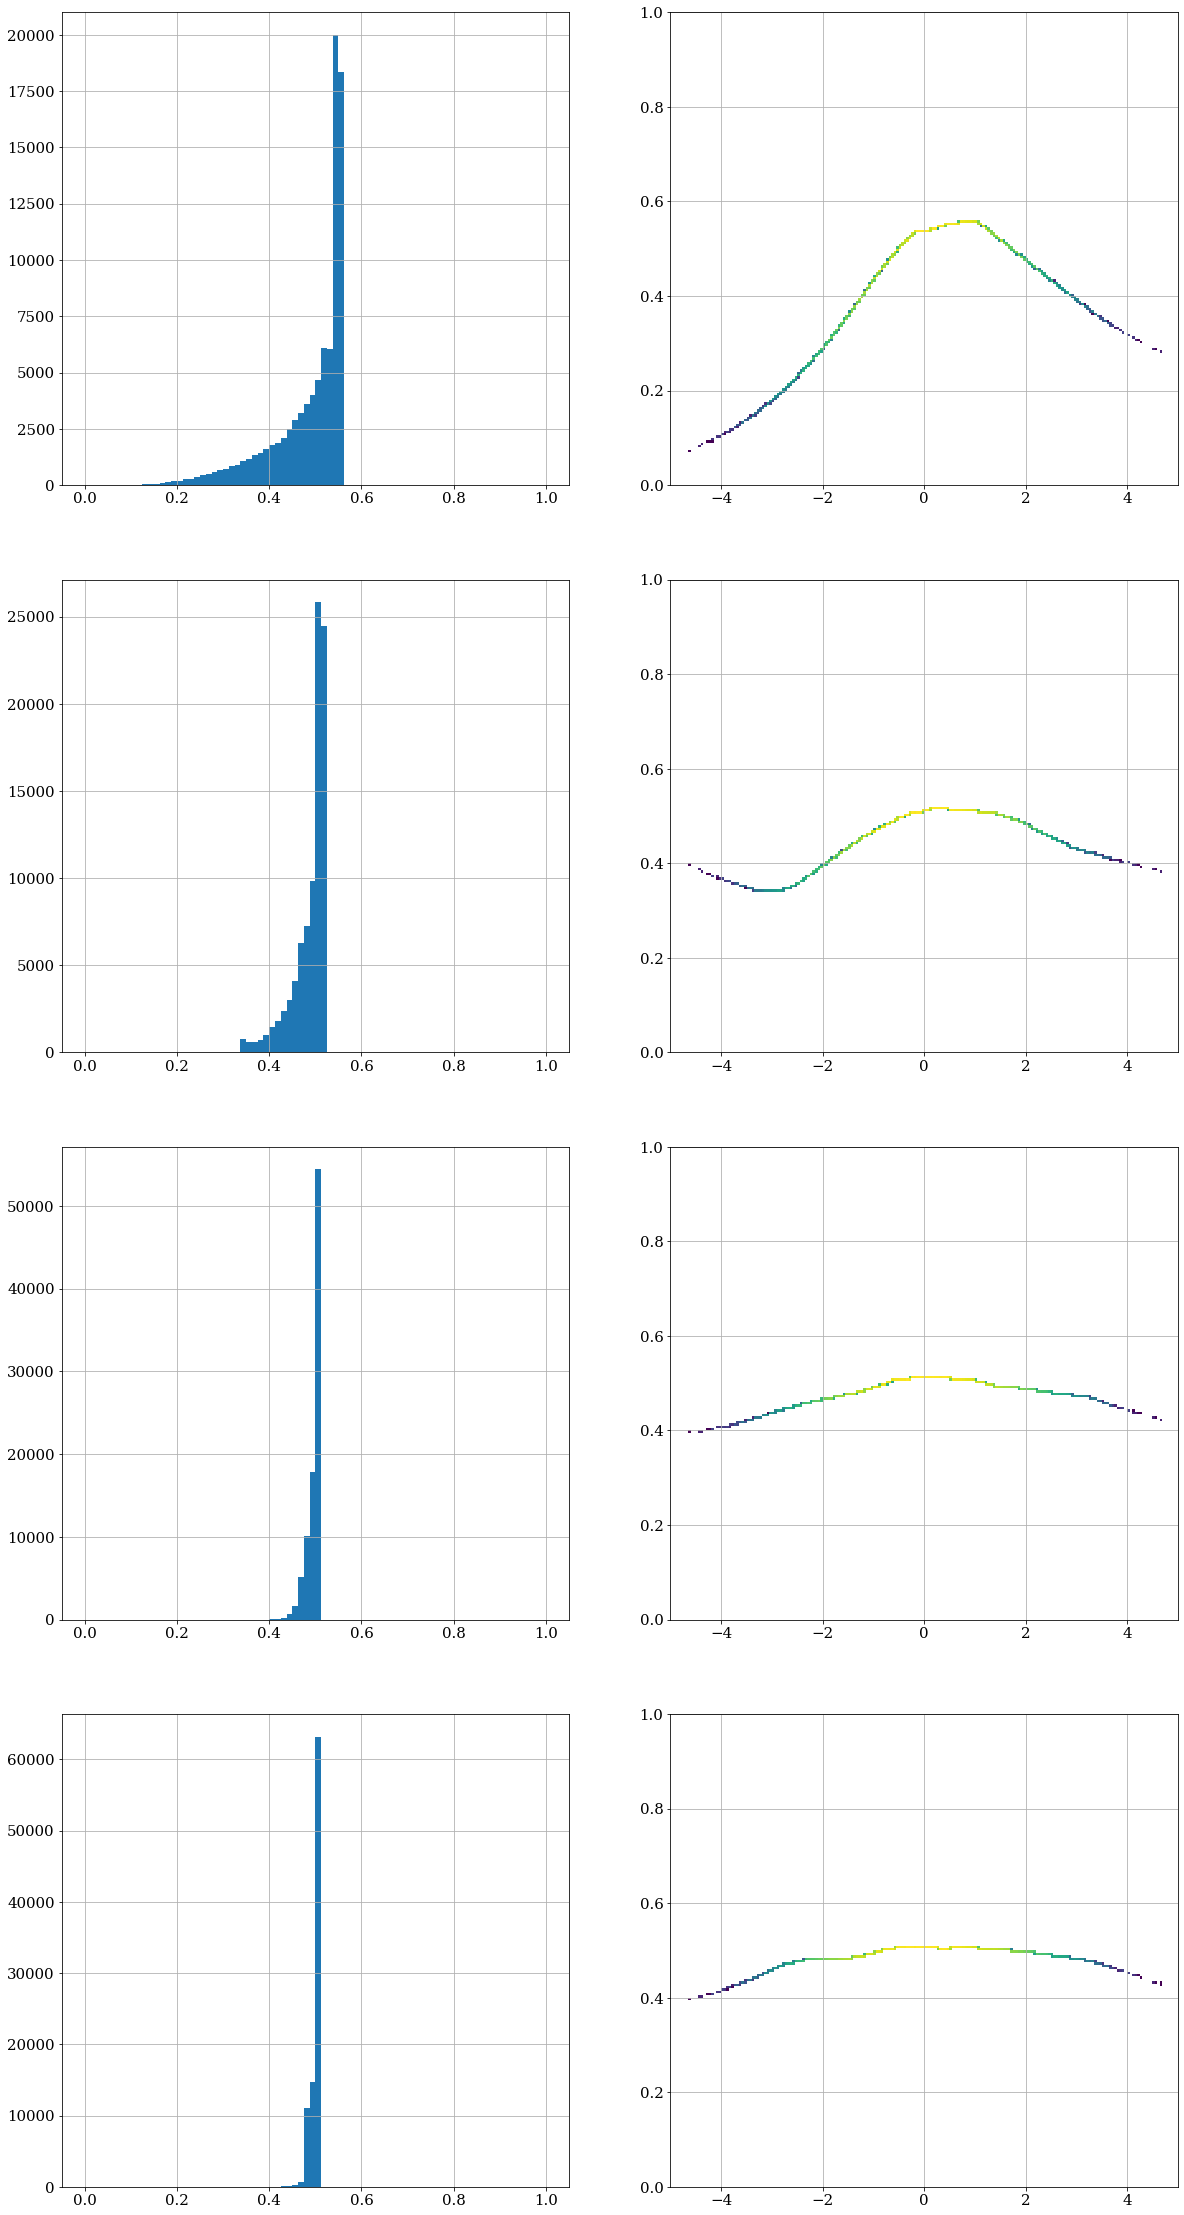

In [75]:
fig,ax = plt.subplots(iterations,2,figsize=(20,40))

for i in range(0,iterations):
    
    ax[i][0].hist( nn_output[i,0,theta0_S!=dummyval], bins=80, range=[0,1] )
    ax[i][0].grid()
    
    ax[i][1].hist2d( theta0_S[theta0_S!=dummyval], nn_output[i,0,theta0_S!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[0,1]))
    ax[i][1].grid()
    
plt.show()

## NN output of step2 : distinguish gen

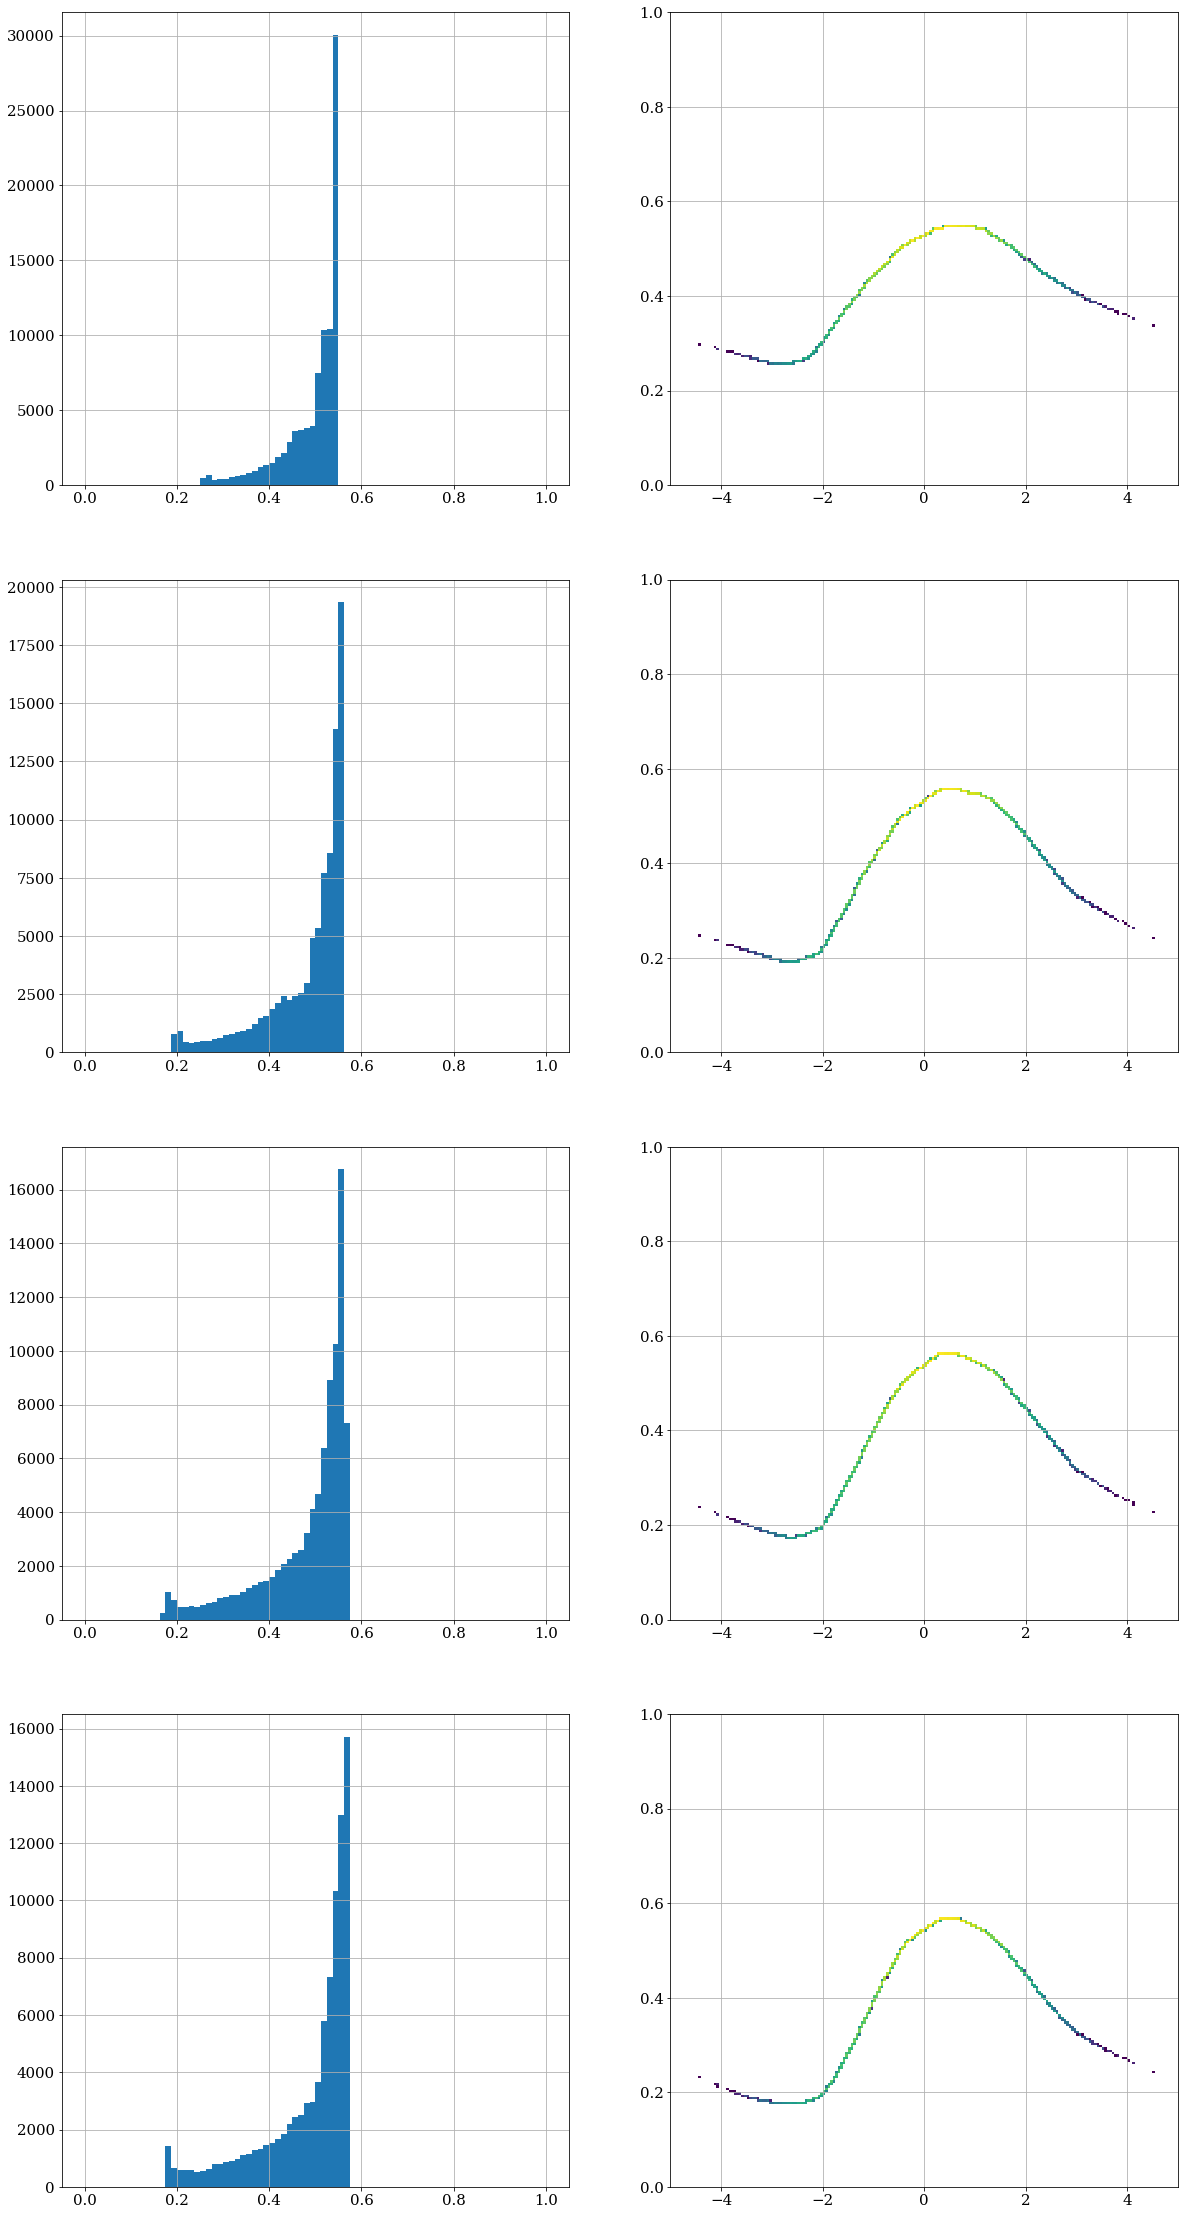

In [78]:
fig,ax = plt.subplots(iterations,2,figsize=(20,40))

for i in range(0,iterations):
    
    ax[i][0].hist( nn_output[i,1,theta0_G!=dummyval], bins=80, range=[0,1] )
    ax[i][0].grid()
    
    ax[i][1].hist2d( theta0_G[theta0_G!=dummyval], nn_output[i,1,theta0_G!=dummyval], 
                    bins=200, norm=mpl.colors.LogNorm(),
                   range=([-5,5],[0,1]))
    ax[i][1].grid()
    
plt.show()